# Table of contents <a name="contents"></a>
1. [Multilayer Perceptron Introduction](#multilayer)
2. [Model Architecture Definition and Training Strategy](#archi-train)
3. [MLP Implementation](#mlp-implementation)
4. [Evaluate the Model](#evaluation)
    - 4.1. [Augmented dataset's cross validation](#cross-augmented)
    - 4.2. [Original dataset's cross validation](#cross-original)
    - 4.3. [Average Cross validation and precision per class](#avg-precision)
5. [Conclusion](#conclusion)

### 1. Multilayer Perceptron Introduction (MLP) 
We are going to use **Multilayer Perceptron (MLP)** because it is a flexible neural network architecture. MLPs are great for solving **classification problems**

For this model we will define the model architecture and the training strategy consisting in:
- **Number of layers**
- **Number of neurons of each layer**
- **Choice of the activation functions**
- **Optimizer** 
- **Learning hyperparameters** (e.g., learning rate, mini-batch size, number of epochs, etc.)
- **Regularization techniques to adopt** (e.g., early stopping, weight regularization, dropout)

The network works by processing data through **multiple layers**, with each layer learning to capture different features of the input data.

### 2. Model architecture definition and Training Strategy <a name="archi-train"></a>

For the architecture of our MLP model we need, as mentioned above, the number of layers, neurons, and choose the activation functions such as relu, softmax and Tanh for example.

We used **dictionaries** to organize and store different options for **hyperparameters**. This allows us to easily experiment with different configurations and manage the settings efficiently.

To optimize our model, we decided to do a grid search to **update and select the best hyperparameter combination in the first iteration**. This means that in the beginning, we test several combinations of hyperparameters to find the one that performs best. By doing this, we can quickly narrow down the best model for our task, improving the **accuracy** of the predictions.

Additionally, we will use the **ADAM** optimizer, which is a popular choice for training neural networks due to its adaptive learning rate and efficient performance.
We also implemented **early stopping** to prevent overfitting by monitoring the model's performance and halting training when it stops improving.

In this way, the process of **testing and updating** in the first iteration helps us fine-tune the model efficiently, and **selecting the best combination** ensures we are using the most effective settings for our dataset.

The following table defines the possible combinations of hyperparameters we tested:

| <span style="color: #C70039;">**Hyperparameter**</span> | <span style="color: #C70039;">**Options**</span>        |
|-----------------------------------------------------|-------------------------------------------------------|
| <span style="color: #00bfae;">**Hidden Units**</span> | [128, 64, 32], [256, 128, 64], [256, 128, 64, 32]                |
| <span style="color: #00bfae;">**Activation Functions**</span> | reLU, sigmoid, tanh                             |
| <span style="color: #00bfae;">**Dropout Rate**</span> | 0.2, 0.3, 0.4                                         |
| <span style="color: #00bfae;">**Batch Size**</span>   | 32, 64                                               |
| <span style="color: #00bfae;">**Epochs**</span>       | 20, 50                                                 |
| <span style="color: #00bfae;">**Regularizations**</span>       | None, L1 (Lasso), L2 (Ridge)                                            |
| <span style="color: #00bfae;">**Learning Rate**</span> | 0.001, 0.0001                                     |


<span style="color: #C70039;">**Note:**</span>
- <span style="color: #00bfae;">**Hidden Units**</span> consists in the number of layers and the number of each neurons of each layer, for example in this case [256, 128, 64], it defines 3 layers with 256, 128 and 64 neurons, respectively.


### 3. MLP Implementation  <a name="mlp-implementation"></a>
[[go back to the top]](#contents)

Here we start the MLP implementation with the provided explanation of our workflow.

##### Imports

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
from pathos.multiprocessing import Pool
import random 
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tabulate import tabulate


##### Class MLP
[[go back to the topic]](#mlp-implementation)

Defines a flexible Multi-Layer Perceptron (MLP) with configurable layers, dropout, activation functions, and optional **l1** or **l2** regularization. Includes a method to compute regularization loss for better generalization.

In [3]:
class MLP(tf.keras.Model):
    def __init__(self, input_dim, output_dim, hidden_units, dropout_rate, activations, regularization_type=None, regularization_value=0.01):
        super(MLP, self).__init__()
        self.hidden_layers = []
        self.regularization_type = regularization_type
        self.regularization_value = regularization_value

        for units, activation in zip(hidden_units, activations):
            self.hidden_layers.append(
                tf.keras.layers.Dense(units, activation=activation)
            )
            self.hidden_layers.append(tf.keras.layers.Dropout(dropout_rate))
        
        self.output_layer = tf.keras.layers.Dense(output_dim, activation='softmax')  


    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)
    
    def compute_regularization_loss(self):
        regularization_loss = 0.0
        if self.regularization_type:
            for layer in self.hidden_layers:
                if isinstance(layer, tf.keras.layers.Dense):
                    weights = layer.kernel
                    if self.regularization_type == 'l1':
                        regularization_loss += tf.reduce_sum(tf.abs(weights)) * self.regularization_value
                    elif self.regularization_type == 'l2':
                        regularization_loss += tf.reduce_sum(tf.square(weights)) * self.regularization_value
        return regularization_loss

##### Hyperparameter Configuration Generator and Load Fold Data
[[go back to the topic]](#mlp-implementation)

Generates all possible combinations of hyperparameter configurations from a dictionary of options using Cartesian product. Loads features and labels from a specific fold's dataset file, separating the Label column from the feature matrix for training and evaluation purposes.

In [4]:
def generate_configs(configurations):
    keys, values = zip(*configurations.items())
    return [dict(zip(keys, v)) for v in itertools.product(*values)]

def load_fold_data(fold_number, files):
    data = pd.read_csv(files[fold_number])
    labels = data.pop('Label').values
    features = data.values
    return features, labels

##### Train, Evaluate, and Cross-Validate MLP
[[go back to the topic]](#mlp-implementation)

This code trains and evaluates the MLP model using a specified configuration and implements single-fold cross-validation. The training process includes a custom loss function that integrates a regularization term to improve generalization, uses early stopping to prevent overfitting, and calculates validation accuracy on the held-out fold.


We will perform just one iteration of cross-validation to reduce complexity, as advised by the professor.

In [ ]:
def train_evaluate_model(config, X_train, y_train, X_val, y_val):
    model = MLP(
        input_dim=X_train.shape[1],
        output_dim=10,
        hidden_units=config['hidden_units'],
        dropout_rate=config['dropout_rate'],
        activations=config['activations'],
        regularization_type=config.get('regularization_type', None),
        regularization_value=config.get('regularization_value', 0.01)
    )
    
    def loss_with_regularization(y_true, y_pred):
        base_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        regularization_loss = model.compute_regularization_loss()
        return base_loss + regularization_loss

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
        loss=loss_with_regularization,
        metrics=['accuracy']
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=config['batch_size'],
        epochs=config['epochs'],
        callbacks=[early_stopping],
        verbose=0
    )
    return history 

# Cross-validation, just one iteration (1 fold)
def cross_validate_model(config, files):
    # Only the first fold for validation
    fold_number = 0
    X_val, y_val = load_fold_data(fold_number, files)
    X_train, y_train = [], []
    
    # Training with other folds
    for i in range(len(files)):
        if i != fold_number:
            X_temp, y_temp = load_fold_data(i, files)
            X_train.append(X_temp)
            y_train.append(y_temp)
    
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    
    # Train and evaluate for this fold
    accuracy = train_evaluate_model(config, X_train, y_train, X_val, y_val)
    return accuracy  

##### Parallel Evaluation and Activation Combination Generation
[[go back to the topic]](#mlp-implementation)

This code enables parallel evaluation of model configurations by performing cross-validation and logging the results (configuration and accuracy). It also generates random activation function combinations for different hidden layer structures, creating varied configurations for testing and optimization. The results are saved in a log file for later analysis.

In [5]:
def evaluate_config_parallel(args):
    config, files = args
    accuracy = cross_validate_model(config, files)
    
    with open("results_log.txt", "a") as f:
        f.write(f"Configuration: {config} | Accuracy: {accuracy}\n")
    
    return config, accuracy

def generate_activation_combinations(hidden_units_list, activations_list = ['relu', 'sigmoid', 'tanh'], num_combinations=1):
    activation_combinations = []
    for hidden_units in hidden_units_list:
        layers = len(hidden_units)
        for _ in range(num_combinations):
            random_combination = [random.choice(activations_list) for _ in range(layers)]
            activation_combinations.append((hidden_units, random_combination))  
    return activation_combinations

##### Generate and Select Hyperparameter Configurations
[[go back to the topic]](#mlp-implementation)

This code generates combinations of hidden units, activation functions, and other hyperparameters such as dropout rate, batch size, epochs, and regularization settings. It then creates a list of all possible configurations for model training.

In [6]:
hidden_units_list = [[128, 64, 32], [256, 128, 64], [256, 128, 64, 32]]

activation_combinations = generate_activation_combinations(hidden_units_list)

hidden_units = [combo[0] for combo in activation_combinations]
activations = [combo[1] for combo in activation_combinations]

configurations = {
    "hidden_units": hidden_units,  
    "activations": activations,    
    "dropout_rate": [0.2, 0.3, 0.4],
    "batch_size": [32,64],
    "epochs": [20,50],
    "learning_rate": [0.001, 0.0001],
    "regularization_type": [None, 'l1', 'l2'],
    "regularization_value": [0.01, 0.001],
}

files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1,11)] 

all_configs = generate_configs(configurations)

##### Parallel Evaluation and Best Configuration Selection
[[go back to the topic]](#mlp-implementation)

This code evaluates different model configurations in parallel using multiple workers. It first removes any existing result files (**results_log.txt**) to ensure a clean start. Then, it uses a multiprocessing pool with 8 workers to evaluate each configuration in **all_configs**. The results are logged and the best configuration, based on accuracy, is selected and printed.

In [ ]:
if os.path.exists("results_log.txt"):
    os.remove("results_log.txt")
num_workers = 8
with Pool(num_workers) as pool:
    results = pool.map(evaluate_config_parallel, [(config, files) for config in all_configs])

# Find the best configuration
best_config, best_accuracy = max(results, key=lambda x: x[1])
print(f"Best configuration: {best_config}, Best accuracy: {best_accuracy}")

Best configuration: {'hidden_units': [256, 128, 64], 'activations': ['relu', 'relu', 'relu'], 'dropout_rate': 0.3, 'batch_size': 64, 'epochs': 20, 'learning_rate': 0.0001, 'regularization_type': None, 'regularization_value': 0.01}, Best accuracy: 0.7216494679450989


Based on the optimal hyperparameter configuration identified: **'hidden_units':** [256, 128, 64], **'activations':** ['relu', 'relu', 'relu'], **'dropout_rate':** 0.3, **'batch_size':** 64, **'epochs':** 20, **'learning_rate':** 0.0001, **'regularization_type':** None, **'regularization_value':** 0.01** with a **best accuracy** of 0.7216, we will now implement data augmentation techniques to evaluate and enhance model robustness.

### 4. Evaluate the Model <a name="evaluation"></a>
[[go back to the top]](#contents)

In this section we are going to evaluate the model both on the augmented datasets and the original ones.

In [ ]:
best_config = {
    'hidden_units': [256, 128, 64],
    'activations': ['relu', 'relu', 'relu'],
    'dropout_rate': 0.3,
    'batch_size': 64,
    'epochs': 20,
    'learning_rate': 0.0001,
    'regularization_type': None,
    'regularization_value': 0.01
}

def load_augmented_data(fold_number, augmented_files):
    return load_fold_data(fold_number, augmented_files)

def load_fold_data(fold_number, files):
    data = pd.read_csv(files[fold_number - 1]) 
    if data.empty:
        print(f"Erro: O arquivo {files[fold_number - 1]} está vazio ou não foi carregado corretamente.")
    labels = data.pop('Label').values
    features = data.values
    return features, labels

#### 4.1. Augmented dataset's 10 fold cross validation <a name="cross-augmented"></a>
[[go back to the topic]](#evaluation)

**Cross-Validation Schema**:

   - **1 Fold** for **Testing**: Original data only.
   - **1 Fold** for **Validation**: Original data only.
   - **8 Folds** for **Training**: Augmented data.



Train the model using the augmented training set and the best configuration (`best_config`).

Evaluate the model on the test set after training.

In [ ]:
def cross_validate_with_test_and_plot(files, augmented_files, best_config):
    class_names = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark", 
    "drilling", "engine_idling", "gun_shot", "jackhammer", 
    "siren", "street_music"]
    folds = list(range(1, 11))
    all_histories = []
    all_accuracies = []

    for test_fold in folds:
        #print(f"Analyzing Test Fold {test_fold}")

        train_val_folds = [fold for fold in folds if fold != test_fold]
        fold_accuracies = []

        for val_fold in train_val_folds:
        
            train_folds = [fold for fold in train_val_folds if fold != val_fold]

            X_train, y_train = [], []
            for fold in train_folds:
                X_temp, y_temp = load_augmented_data(fold, augmented_files)
                X_train.append(X_temp)
                y_train.append(y_temp)
            X_train = np.concatenate(X_train, axis=0)
            y_train = np.concatenate(y_train, axis=0)

            # Load validation and test data
            X_val, y_val = load_augmented_data(val_fold, augmented_files)
            X_test, y_test = load_fold_data(test_fold, files)

            # Train and evaluate on validation fold
            history = train_evaluate_model(best_config, X_train, y_train, X_val, y_val)
            all_histories.append((test_fold, val_fold, history))

            model = MLP(
                input_dim=X_train.shape[1],
                output_dim=10,
                hidden_units=best_config['hidden_units'],
                dropout_rate=best_config['dropout_rate'],
                activations=best_config['activations'],
                regularization_type=best_config.get('regularization_type', None),
                regularization_value=best_config.get('regularization_value', 0.01)
            )
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=best_config['learning_rate']),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy']
            )
            model.fit(X_train, y_train, batch_size=best_config['batch_size'], epochs=best_config['epochs'], verbose=0)
            y_pred = np.argmax(model.predict(X_test), axis=1)

            _, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
            fold_accuracies.append(val_accuracy)

            #print(f"Test Fold: {test_fold}, Validation Fold: {val_fold} -> Accuracy: {val_accuracy:.4f}")

        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        all_accuracies.extend(fold_accuracies)

        print(f"Fold {test_fold} Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_accuracy:.4f}")

        # Plot individual fold summary
        plot_test_fold_summary(test_fold, history, y_test, y_pred, class_names)

    final_mean_accuracy = np.mean(all_accuracies)
    final_std_accuracy = np.std(all_accuracies)
    print(f"Final Mean Accuracy: {final_mean_accuracy:.4f}, Std Dev: {final_std_accuracy:.4f}")

    return all_histories

##### Plotting the results
[[go back to the topic]](#cross-augmented)


In [ ]:
def plot_test_fold_summary(test_fold, history, y_test, y_pred, class_names):
    epochs = range(1, len(history.history['accuracy']) + 1)

    fig, axs = plt.subplots(1, 4, figsize=(24, 6)) 

    # Accuracy graph
    axs[0].plot(epochs, history.history['accuracy'], label='Train Accuracy', color='blue')
    axs[0].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axs[0].set_title(f'Test Fold {test_fold} - Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].grid(alpha=0.3)

    # Loss graph
    axs[1].plot(epochs, history.history['loss'], label='Train Loss', color='green')
    axs[1].plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')
    axs[1].set_title(f'Test Fold {test_fold} - Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    axs[1].grid(alpha=0.3)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=axs[2])  
    axs[2].set_title("Confusion Matrix")
    axs[2].set_xticks(range(len(class_names)))
    axs[2].set_xticklabels(class_names, rotation=45, ha='right')
    axs[2].set_yticks(range(len(class_names)))
    axs[2].set_yticklabels(class_names)

    # Precision graph by class
    class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    precision_per_class = [class_report[name]['precision'] for name in class_names]

    axs[3].bar(range(len(class_names)), precision_per_class, color='purple', alpha=0.7)
    axs[3].set_xticks(range(len(class_names)))
    axs[3].set_xticklabels(class_names, rotation=45, ha='right')
    axs[3].set_title("Precision per Class")
    axs[3].set_xlabel("Class")
    axs[3].set_ylabel("Precision")

    plt.tight_layout()
    plt.show()


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 1 Mean Accuracy: 0.5918, Std Dev: 0.0213


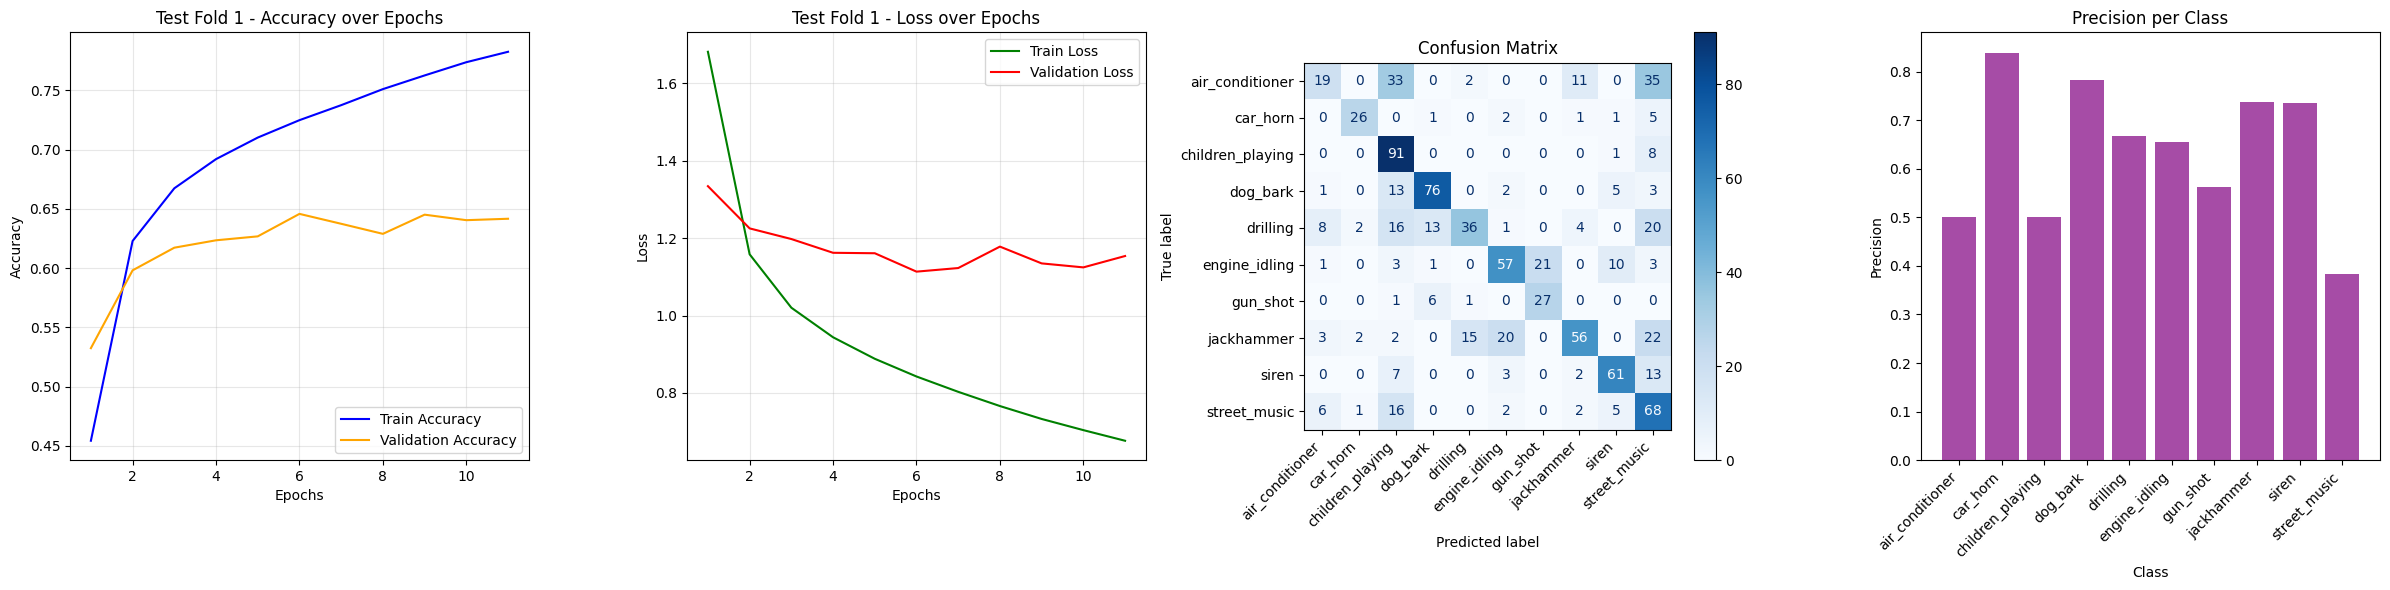

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 2 Mean Accuracy: 0.5787, Std Dev: 0.0231


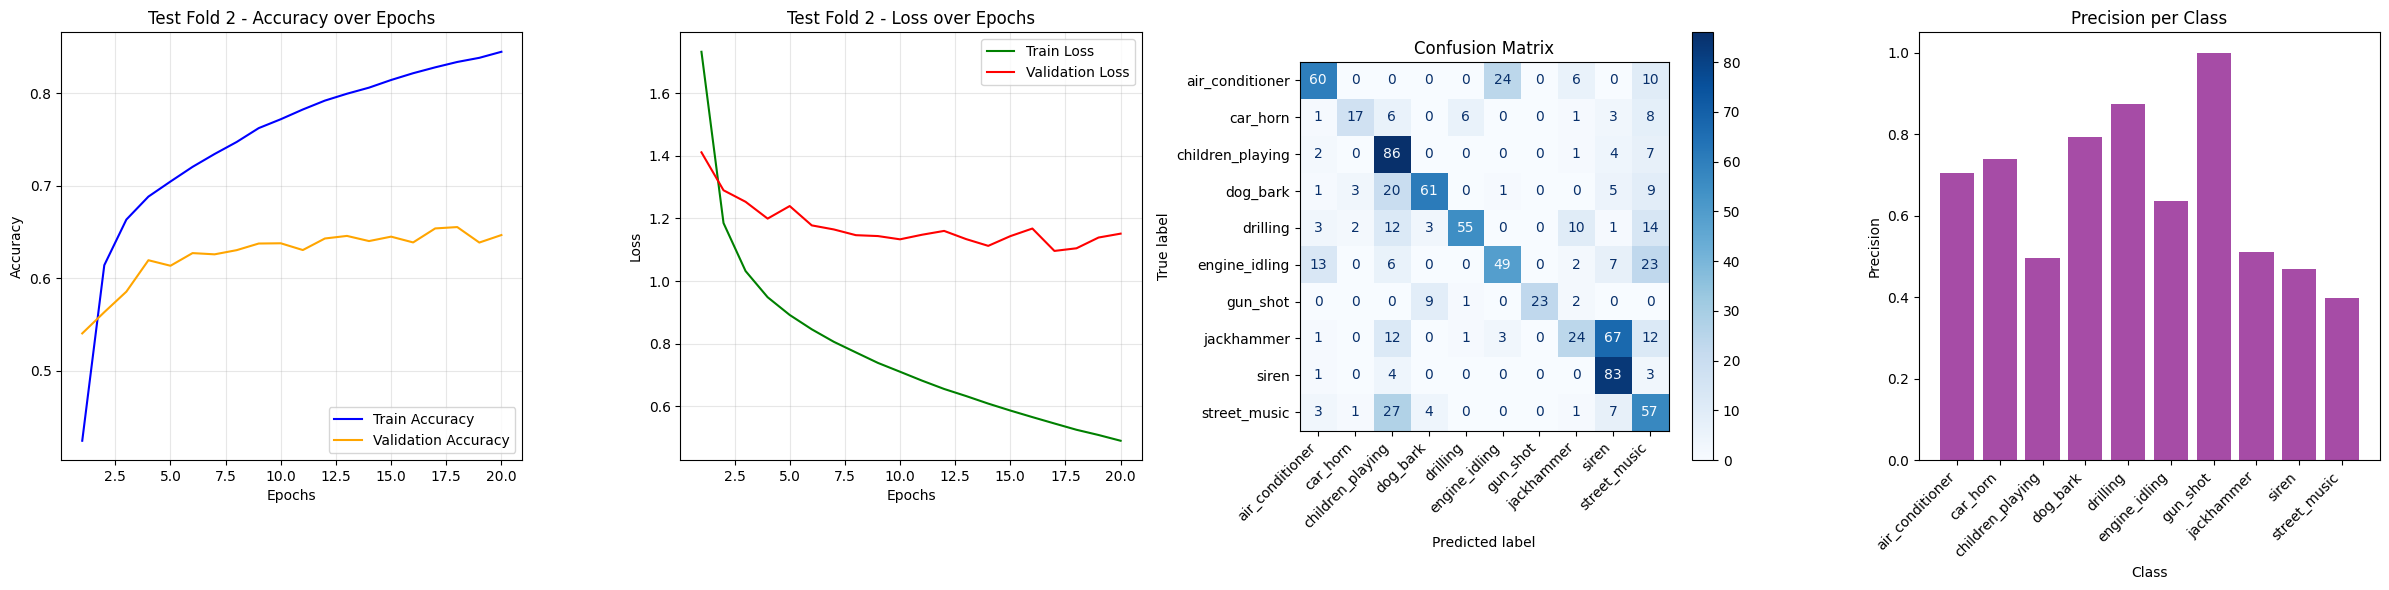

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 3 Mean Accuracy: 0.5219, Std Dev: 0.0197


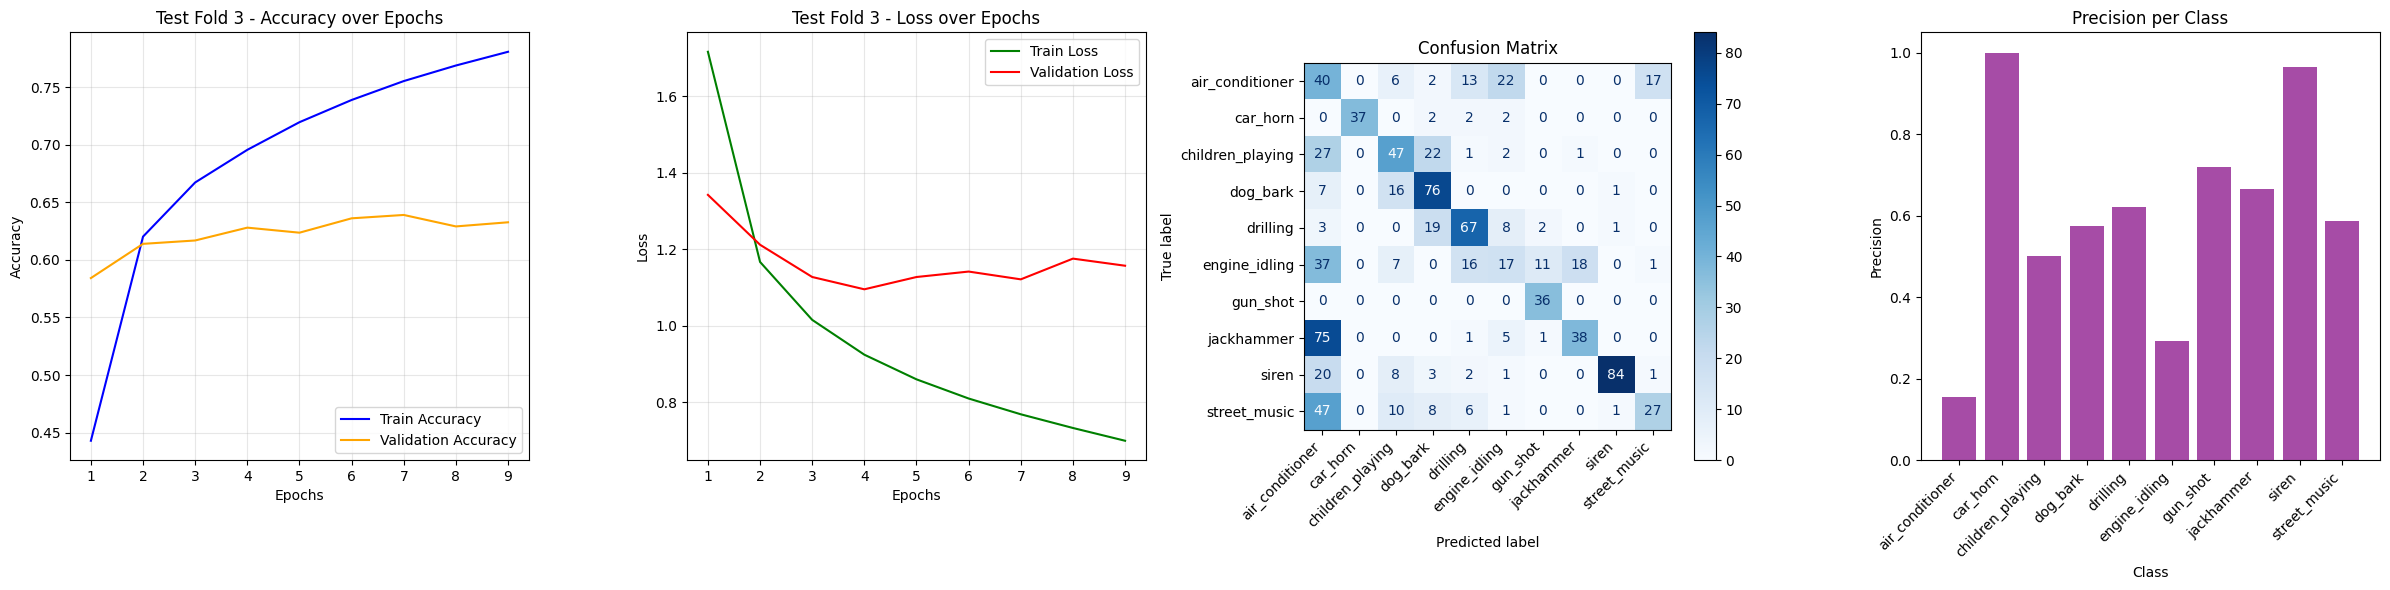

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 4 Mean Accuracy: 0.5981, Std Dev: 0.0190


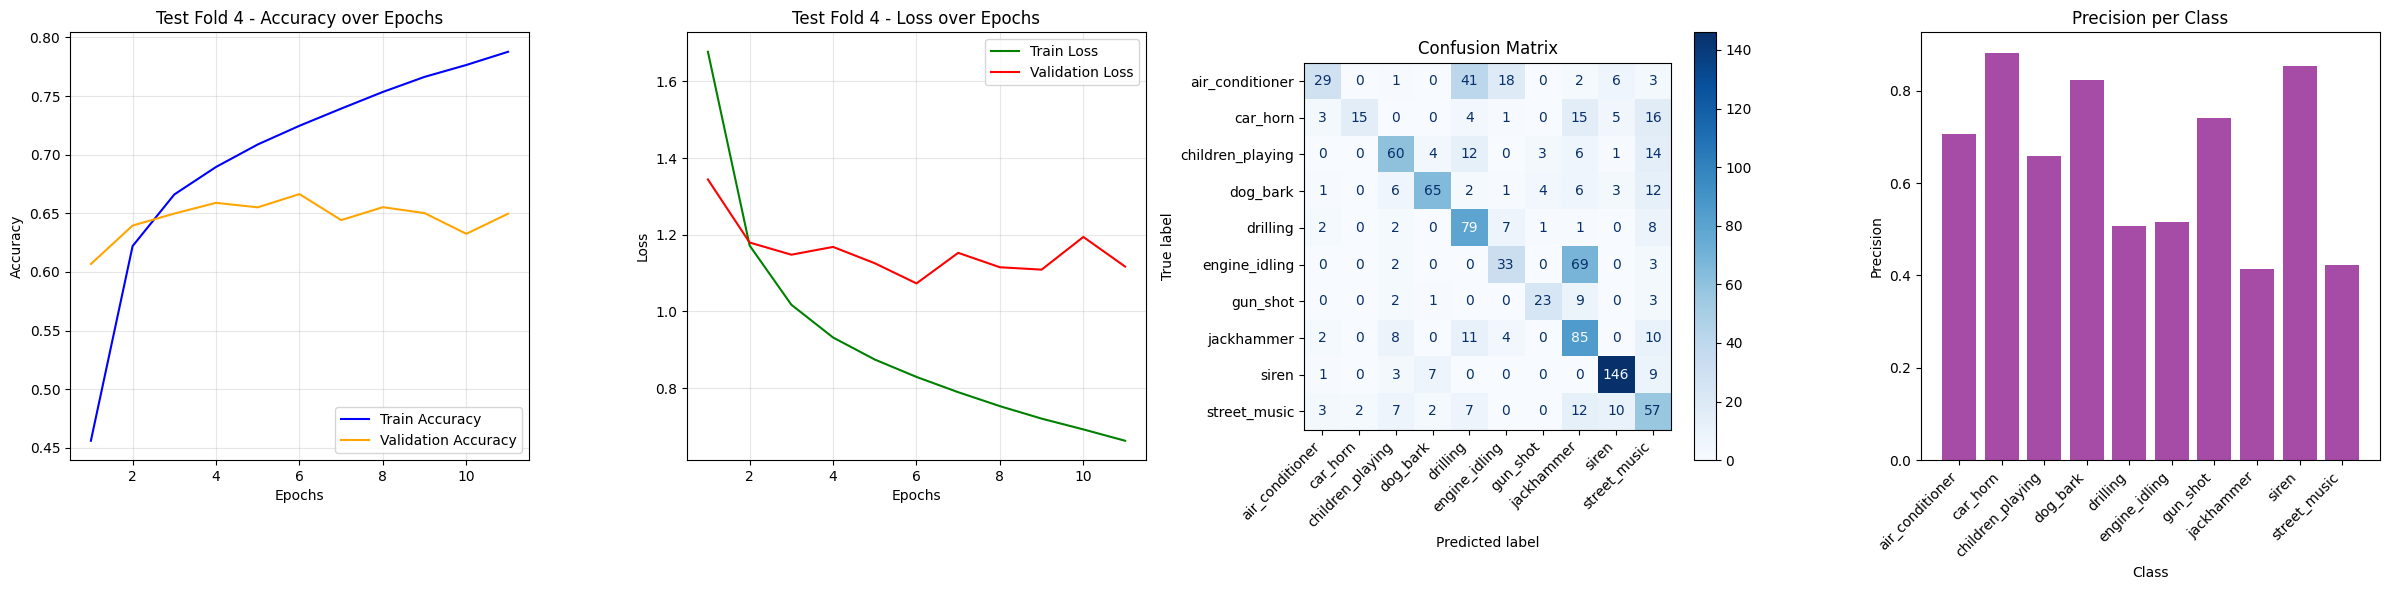

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 5 Mean Accuracy: 0.6753, Std Dev: 0.0207


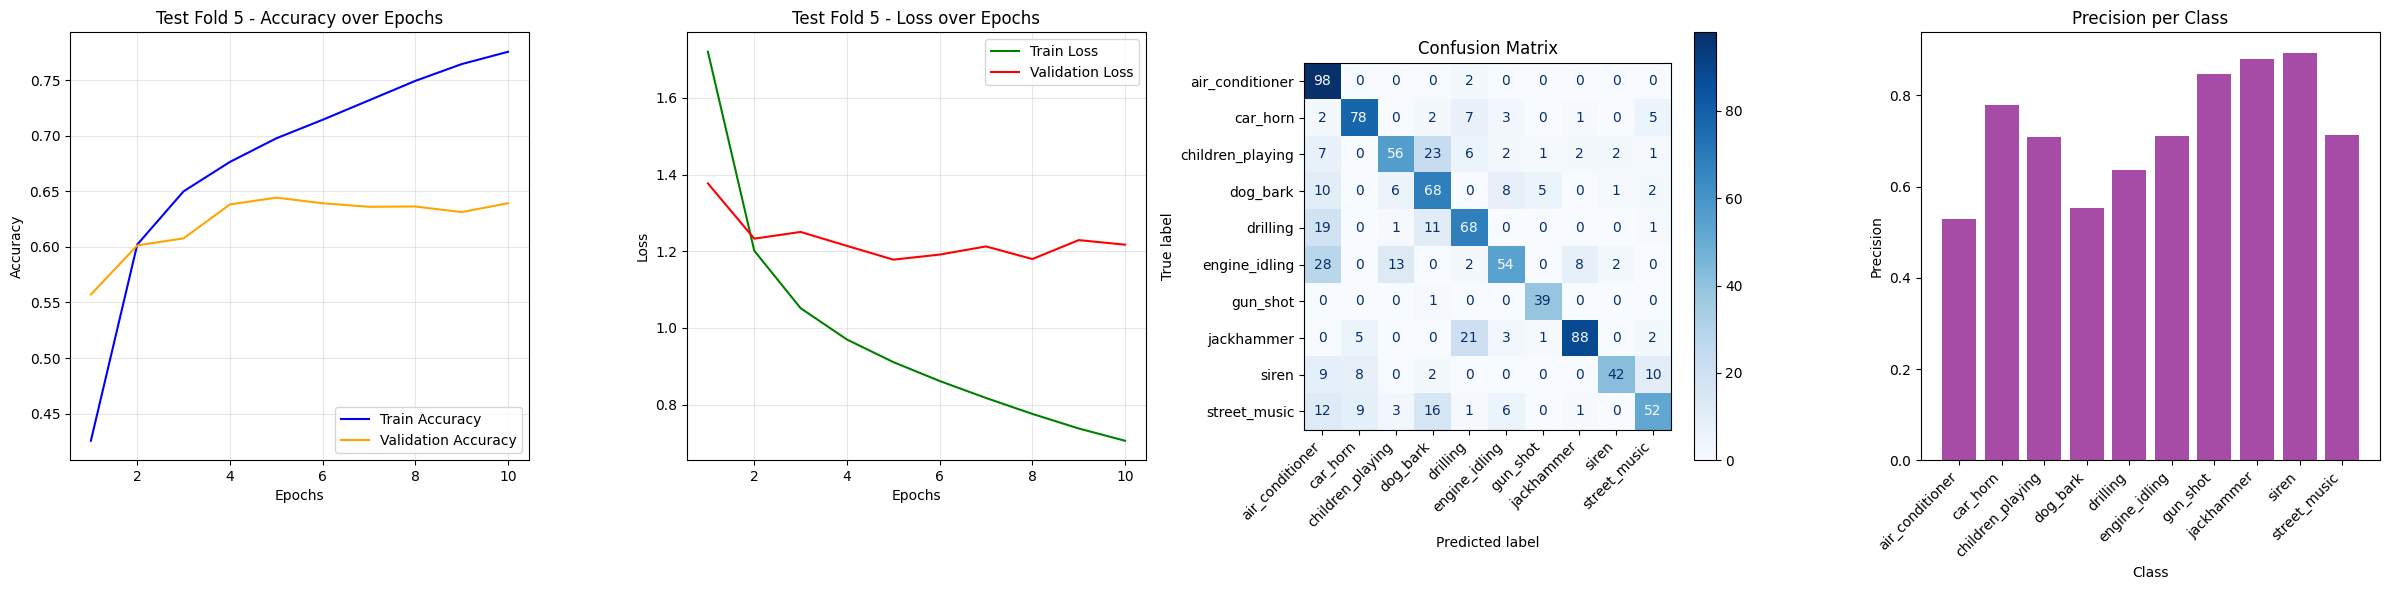

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 6 Mean Accuracy: 0.5373, Std Dev: 0.0205


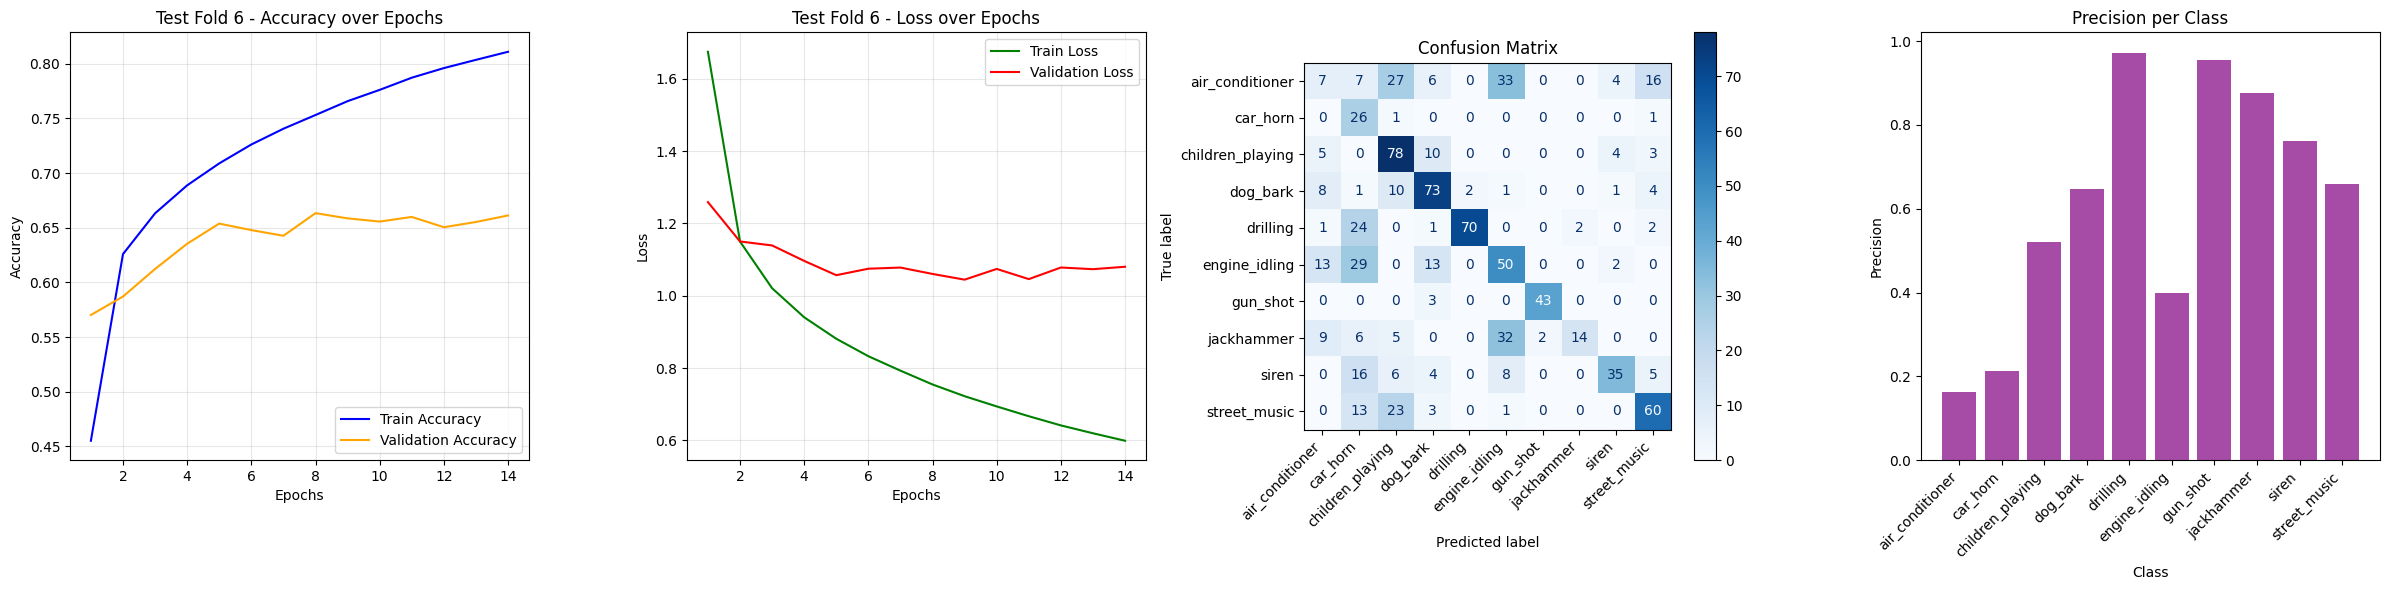

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 7 Mean Accuracy: 0.5626, Std Dev: 0.0410


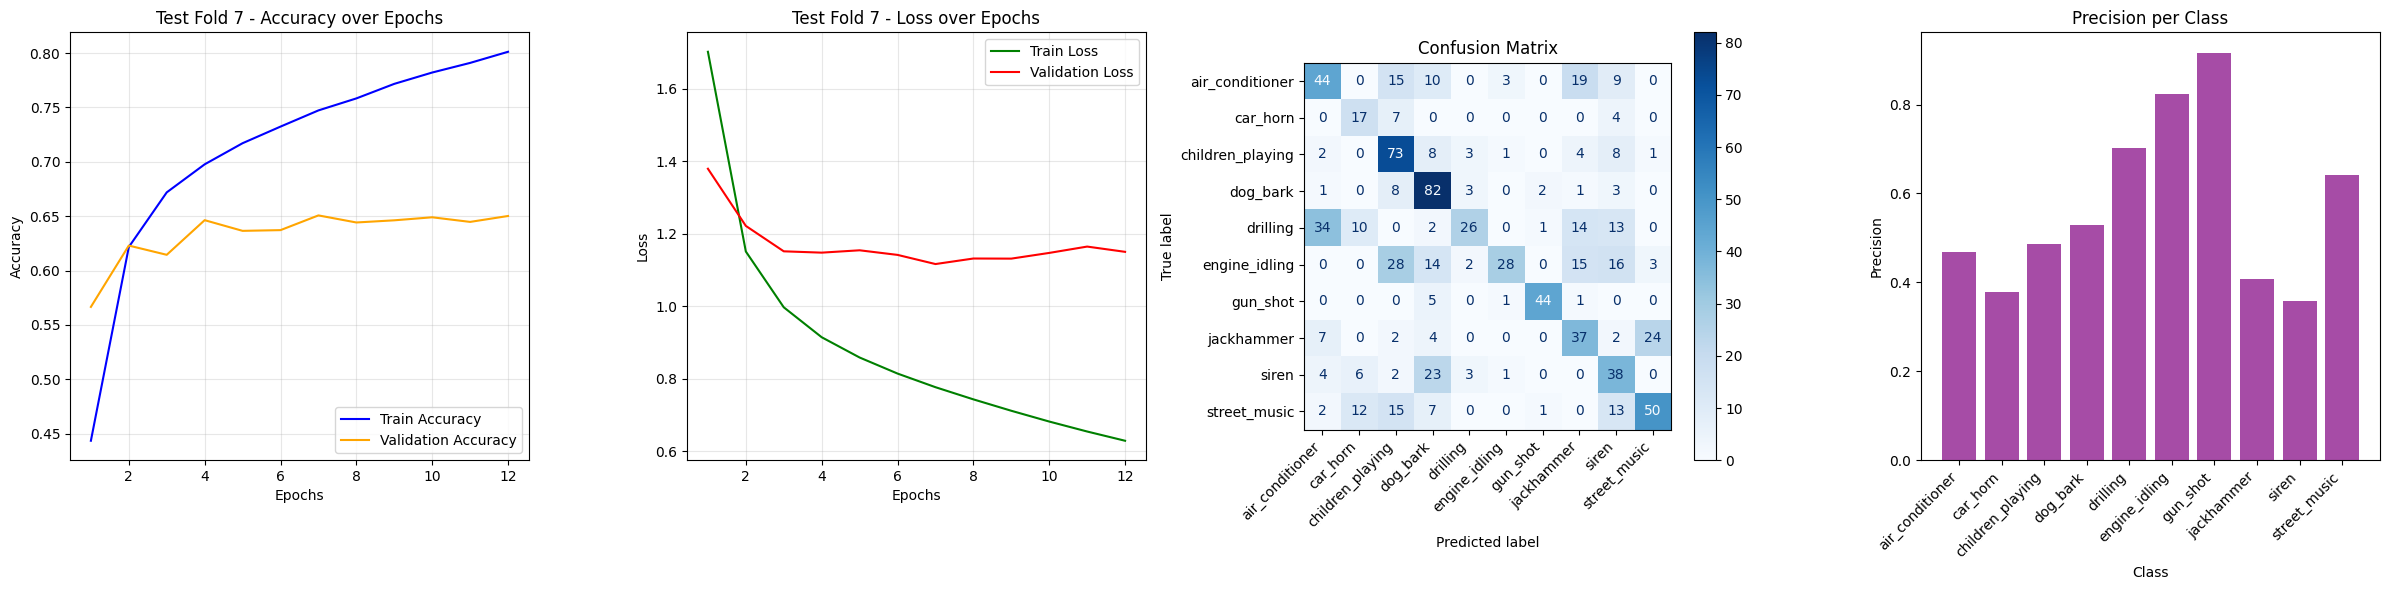

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 8 Mean Accuracy: 0.6304, Std Dev: 0.0192


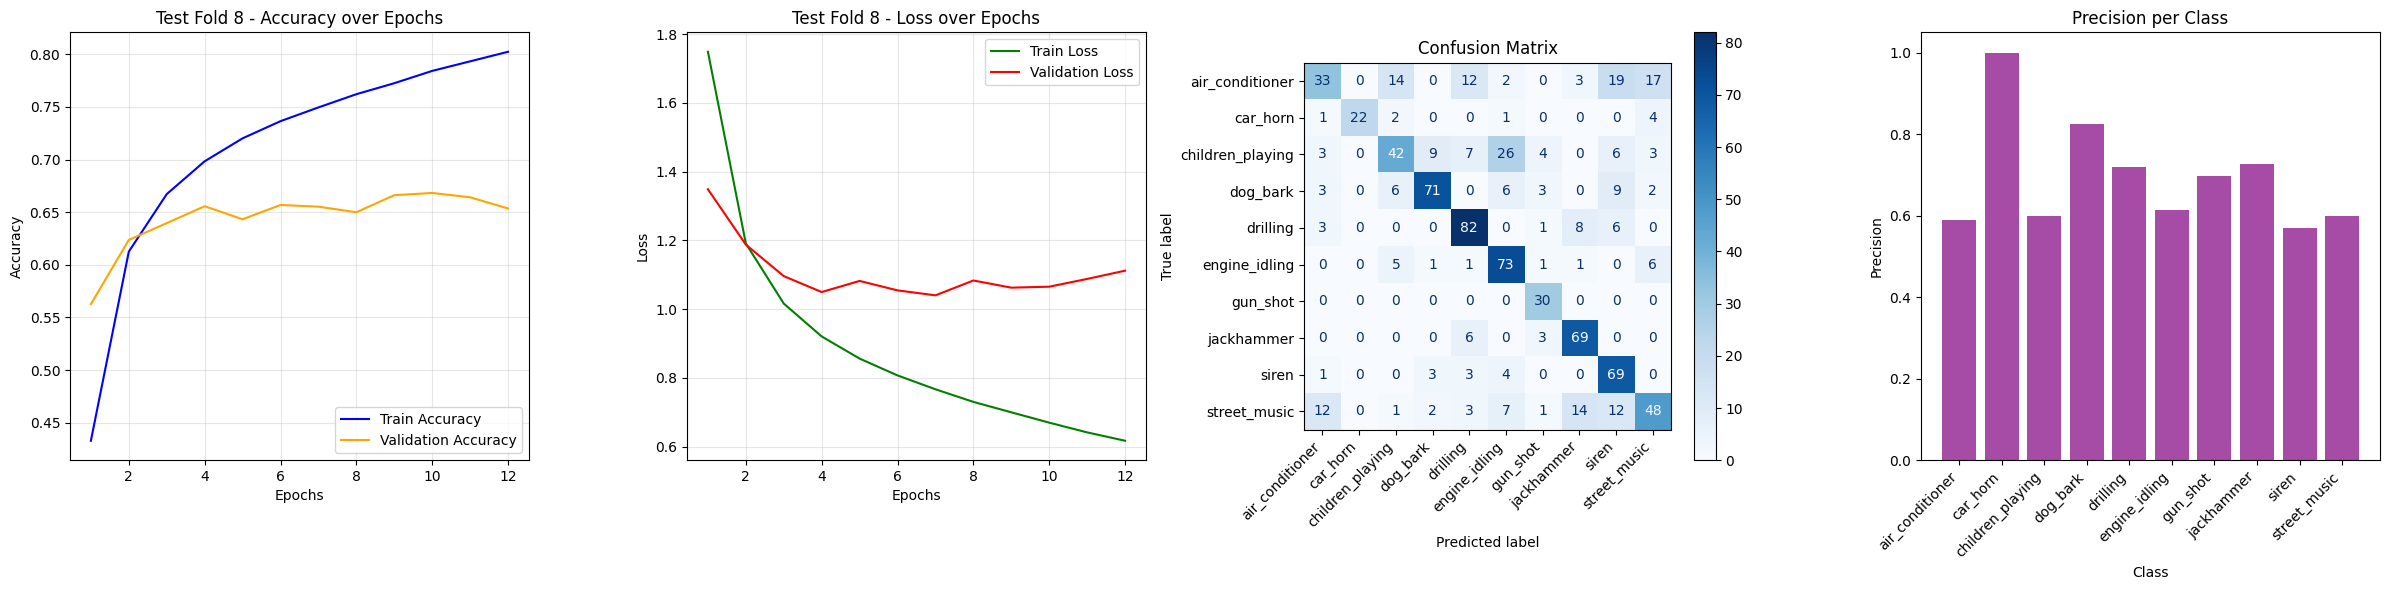

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 9 Mean Accuracy: 0.6503, Std Dev: 0.0379


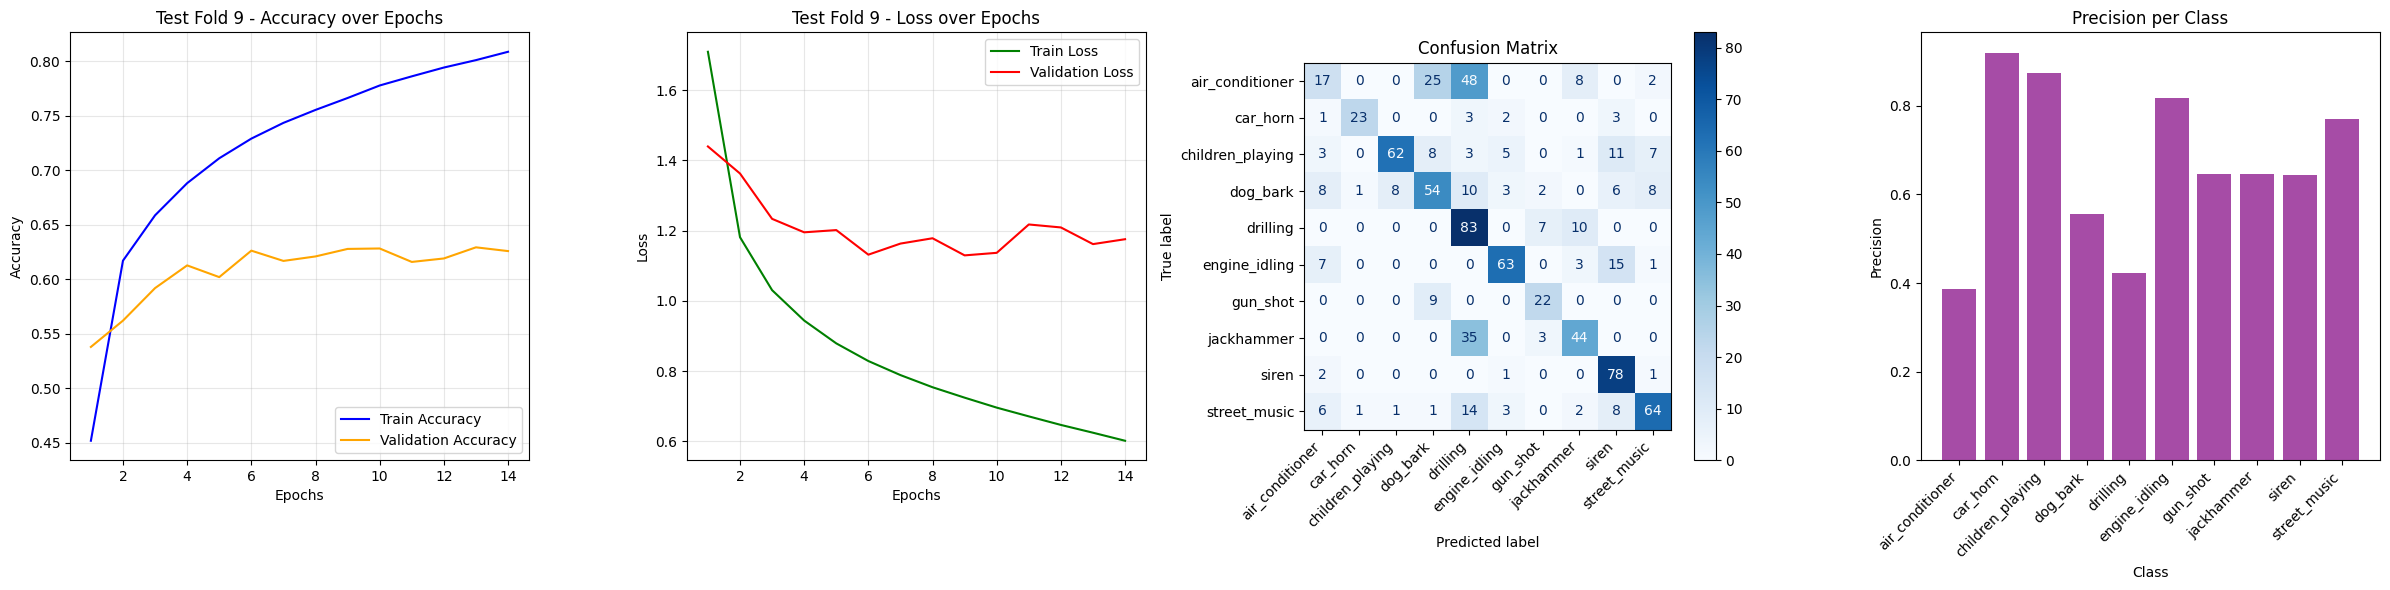

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 10 Mean Accuracy: 0.6276, Std Dev: 0.0446


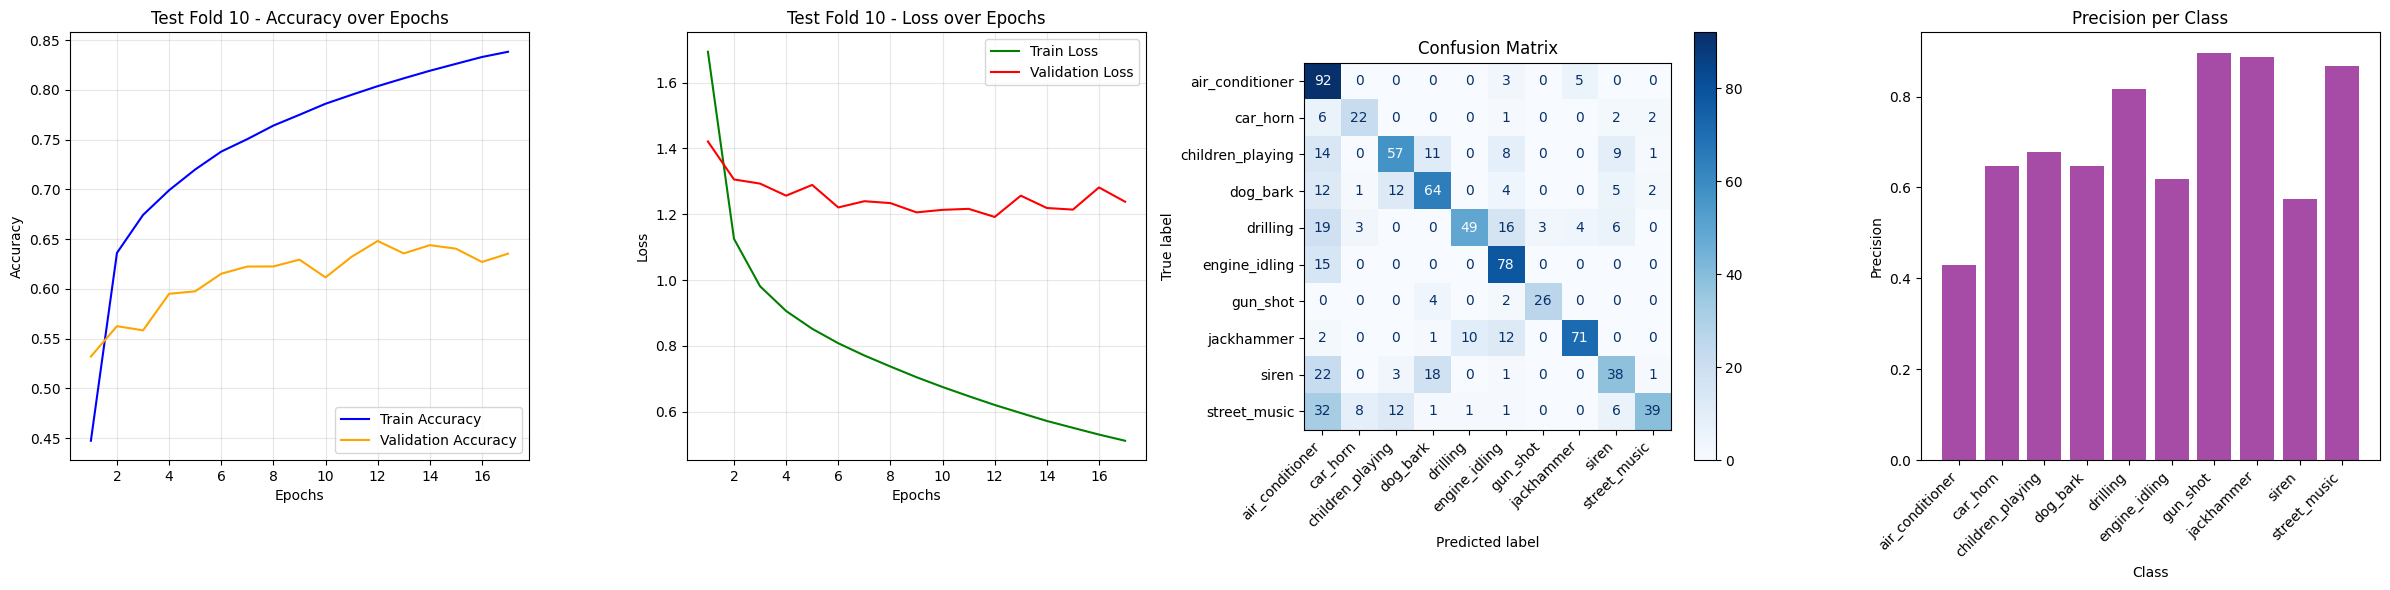

Final Mean Accuracy: 0.5974, Std Dev: 0.0546


[(1, 2, <keras.src.callbacks.history.History at 0x3f791d550>),
 (1, 3, <keras.src.callbacks.history.History at 0x3fa54e7f0>),
 (1, 4, <keras.src.callbacks.history.History at 0x3fcdc1e50>),
 (1, 5, <keras.src.callbacks.history.History at 0x3feab5a30>),
 (1, 6, <keras.src.callbacks.history.History at 0x3fb693760>),
 (1, 7, <keras.src.callbacks.history.History at 0x3cc3aa1f0>),
 (1, 8, <keras.src.callbacks.history.History at 0x3de63f1c0>),
 (1, 9, <keras.src.callbacks.history.History at 0x3f9851460>),
 (1, 10, <keras.src.callbacks.history.History at 0x406039dc0>),
 (2, 1, <keras.src.callbacks.history.History at 0x4060f66a0>),
 (2, 3, <keras.src.callbacks.history.History at 0x409ffc340>),
 (2, 4, <keras.src.callbacks.history.History at 0x40c79b550>),
 (2, 5, <keras.src.callbacks.history.History at 0x40e7bfdf0>),
 (2, 6, <keras.src.callbacks.history.History at 0x4184c0160>),
 (2, 7, <keras.src.callbacks.history.History at 0x40d6015b0>),
 (2, 8, <keras.src.callbacks.history.History at 0x3f0f

In [ ]:
files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]
augmented_files=[f'augmented_datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]

cross_validate_with_test_and_plot(files, augmented_files, best_config)

The mean accuracy for the augmented data was 0.5974 and Std Dev: 0.0546

#### 4.2. Original dataset's 10 fold cross validation <a name="cross-original"></a>
[[go back to the topic]](#evaluation)

The schema is the same as the previous one but this time we only use the original data: 

   - **1 Fold** for **Testing**: Original data.
   - **1 Fold** for **Validation**: Original data.
   - **8 Folds** for **Training**: Original data.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 1 Mean Accuracy: 0.6599, Std Dev: 0.0109


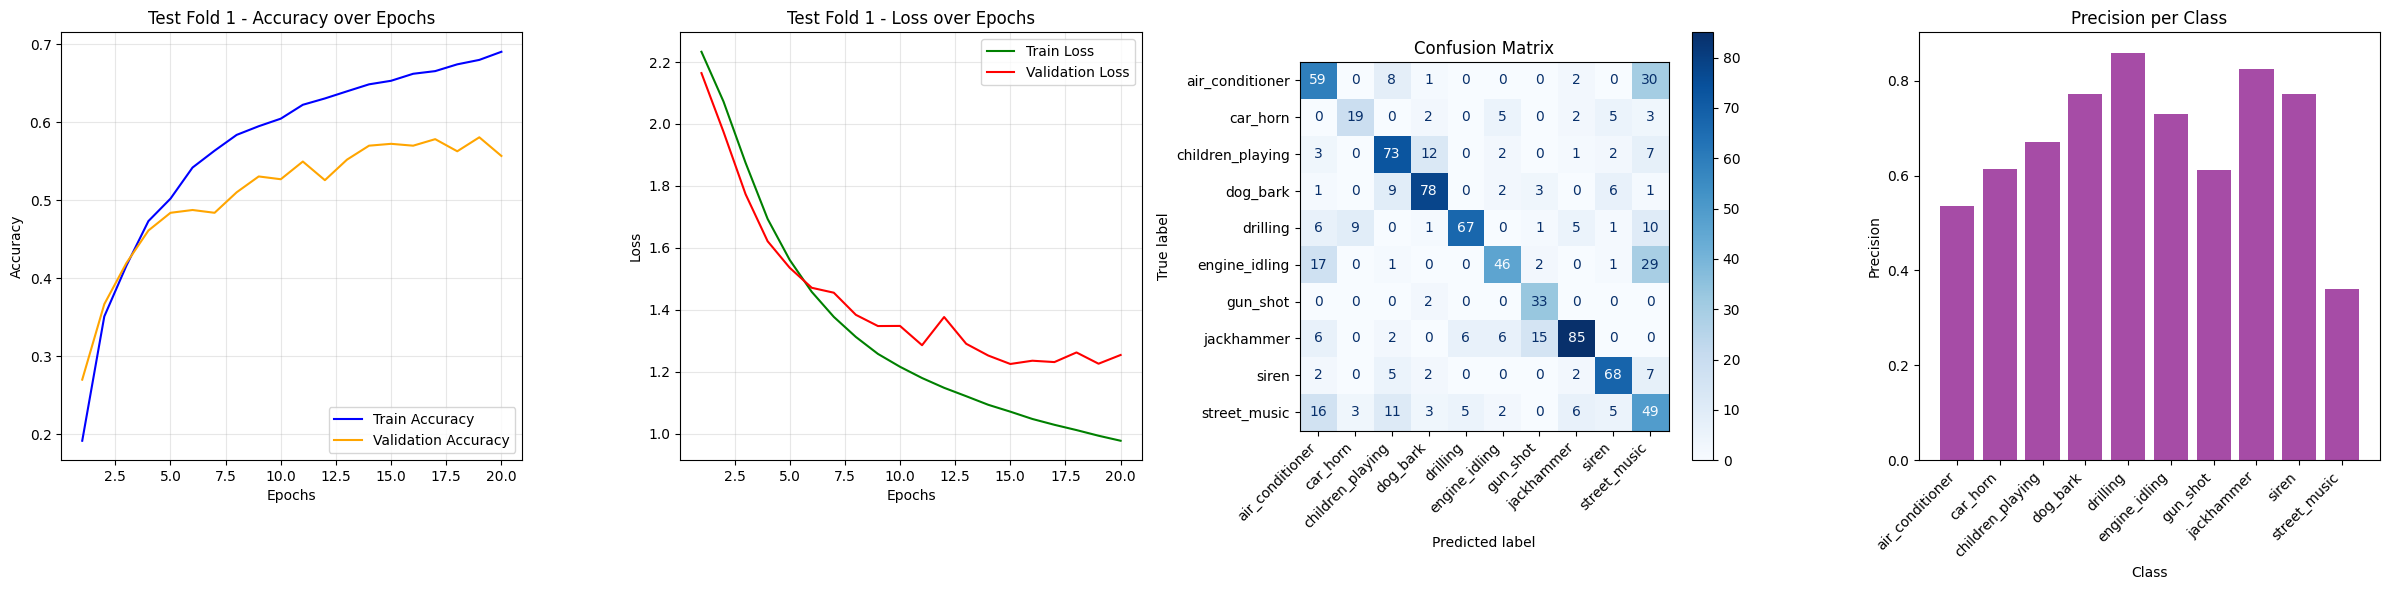

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 2 Mean Accuracy: 0.5532, Std Dev: 0.0200


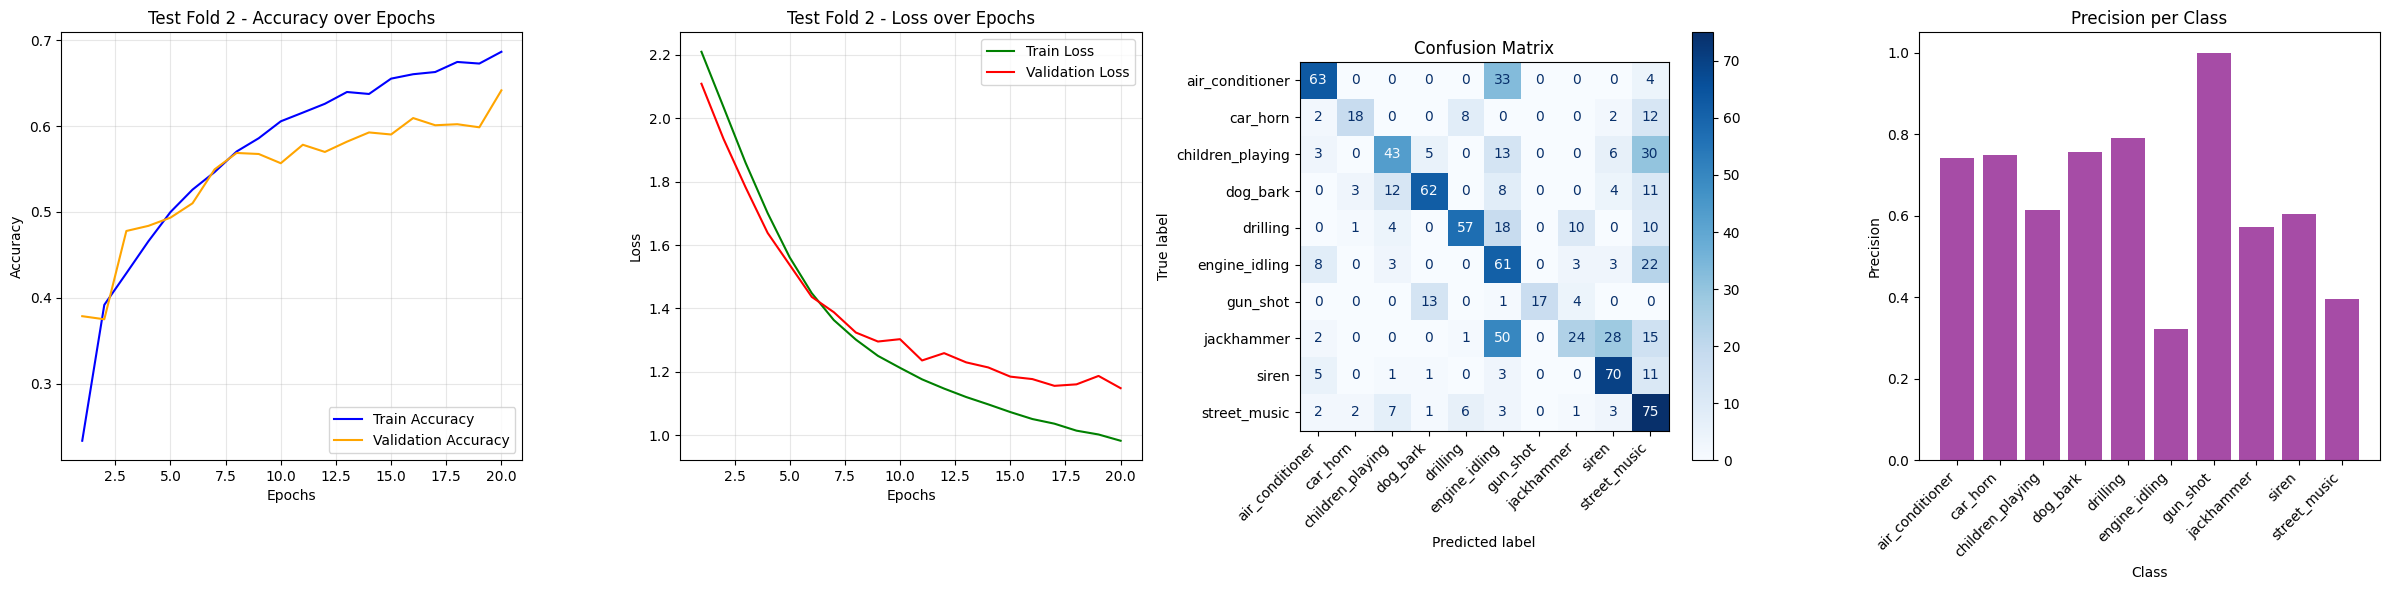

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3 Mean Accuracy: 0.5768, Std Dev: 0.0175


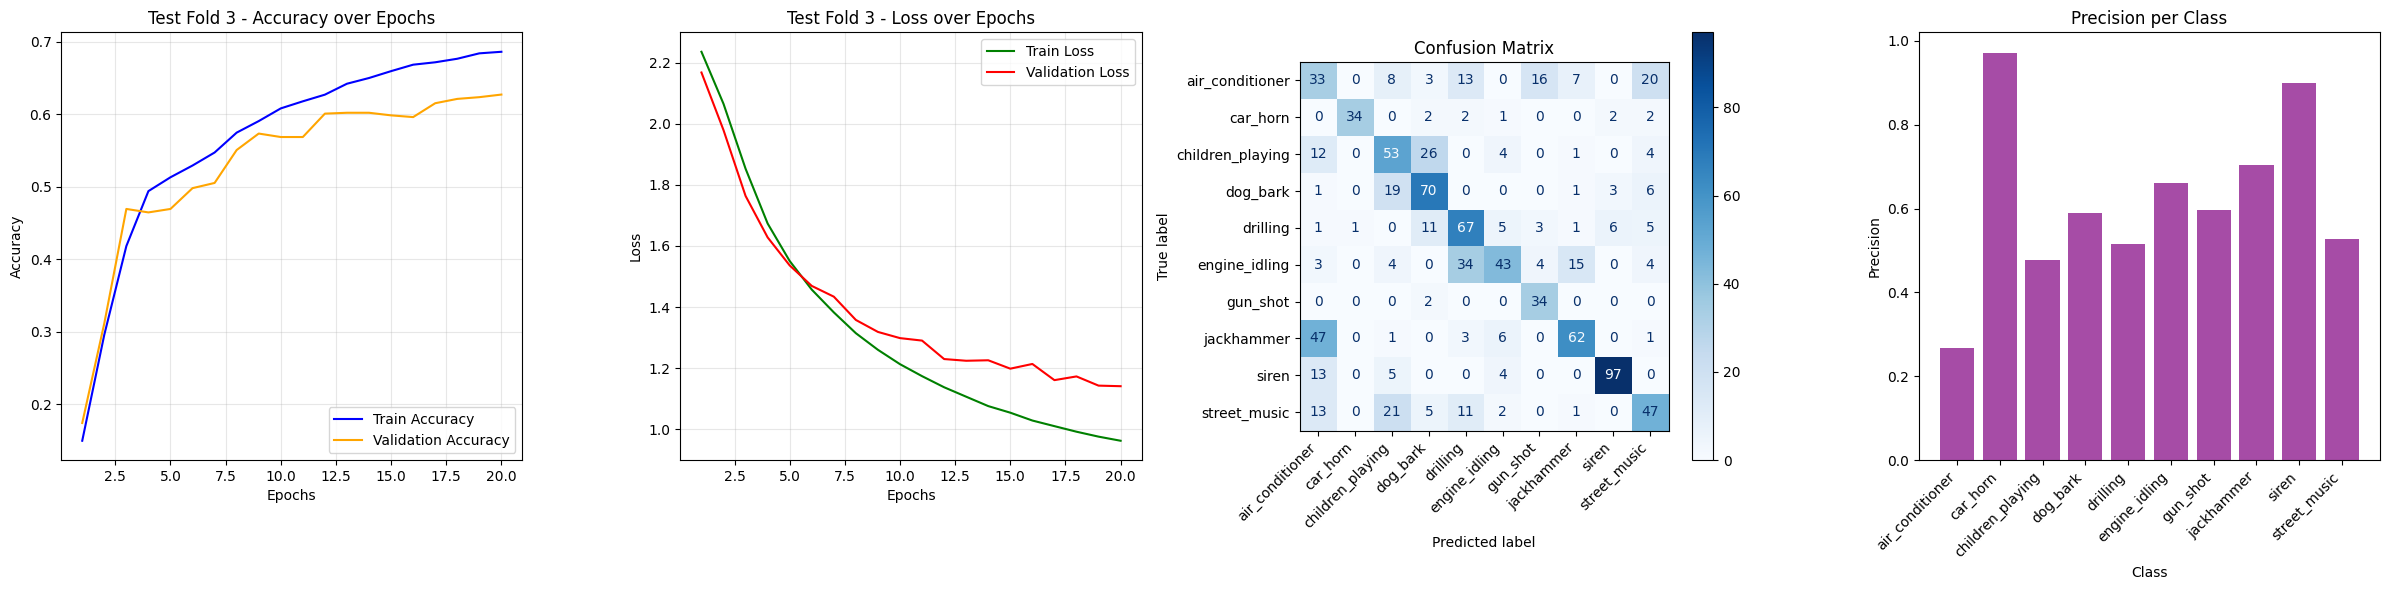

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 4 Mean Accuracy: 0.5916, Std Dev: 0.0155


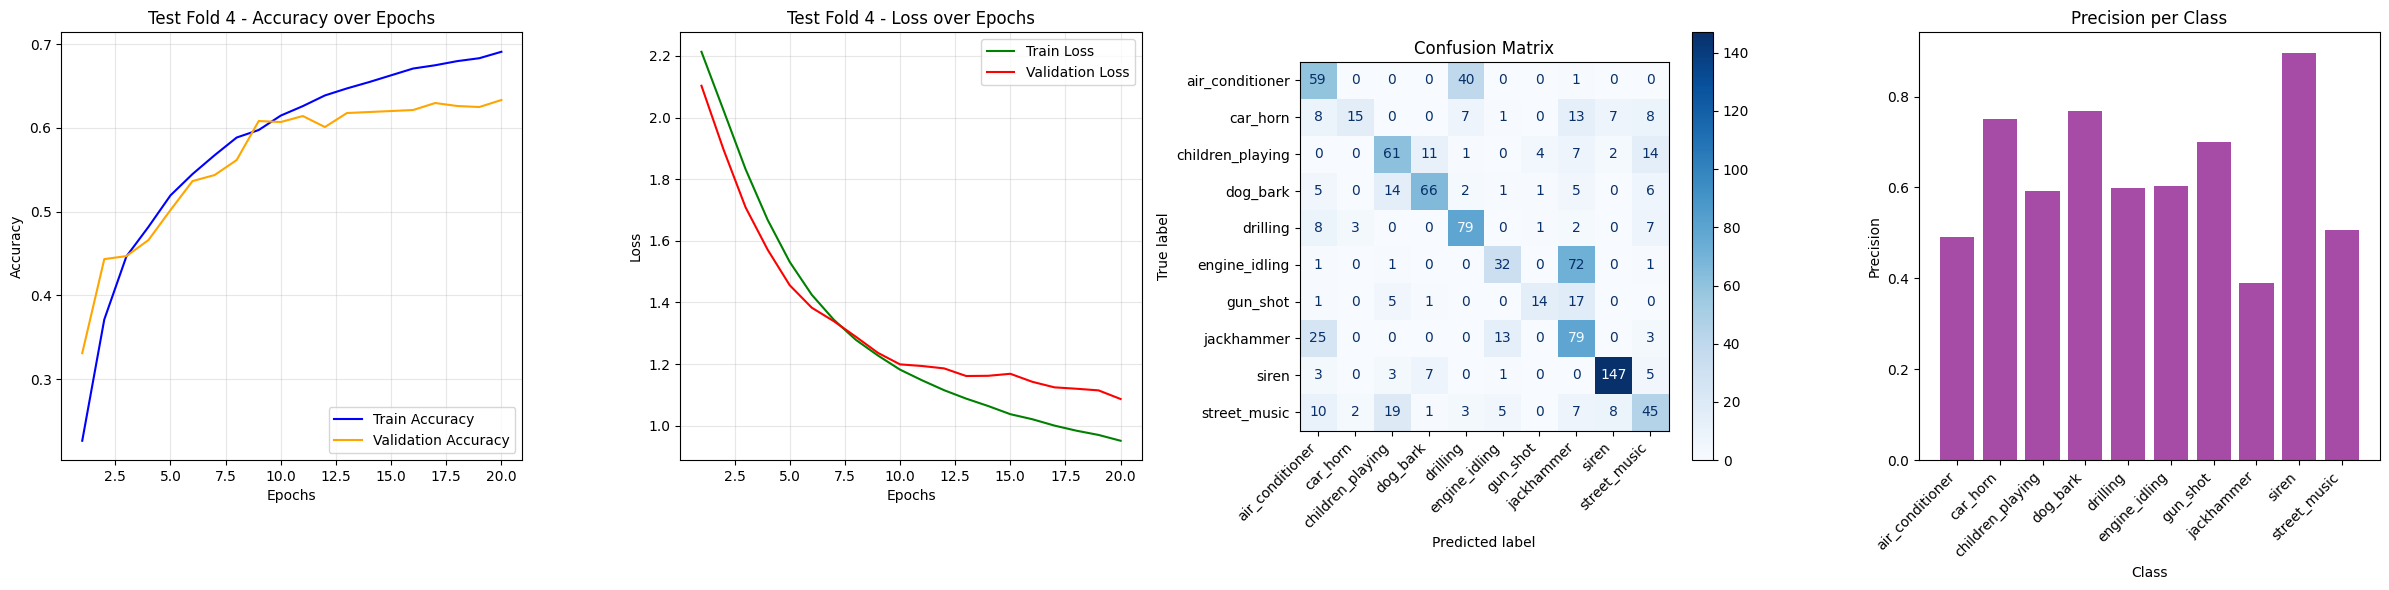

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 5 Mean Accuracy: 0.6299, Std Dev: 0.0209


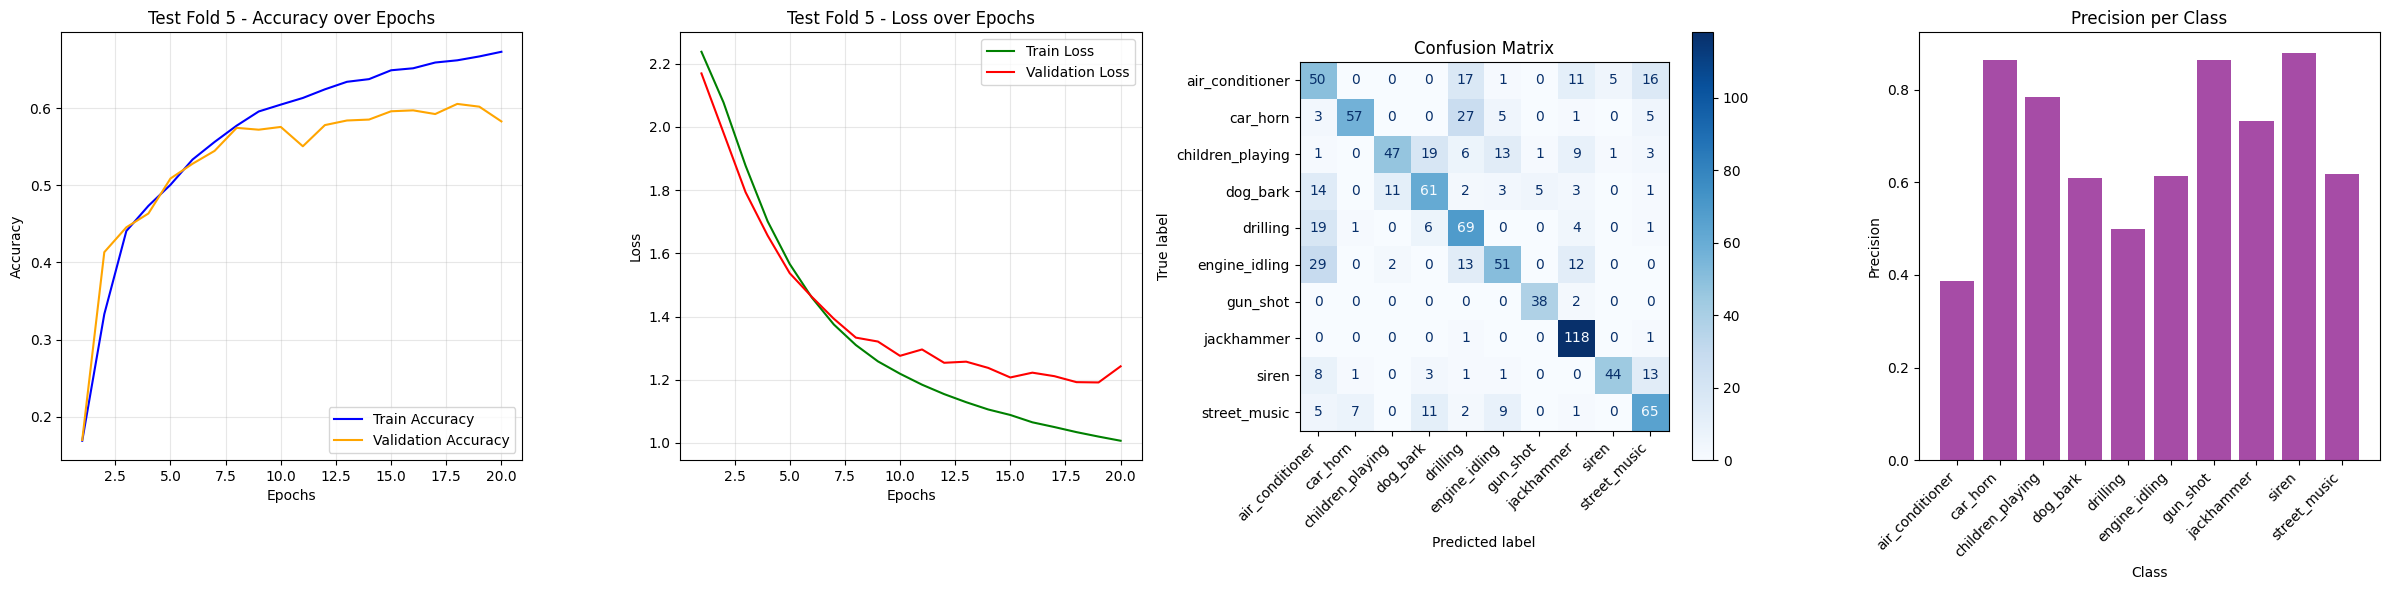

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 6 Mean Accuracy: 0.5303, Std Dev: 0.0284


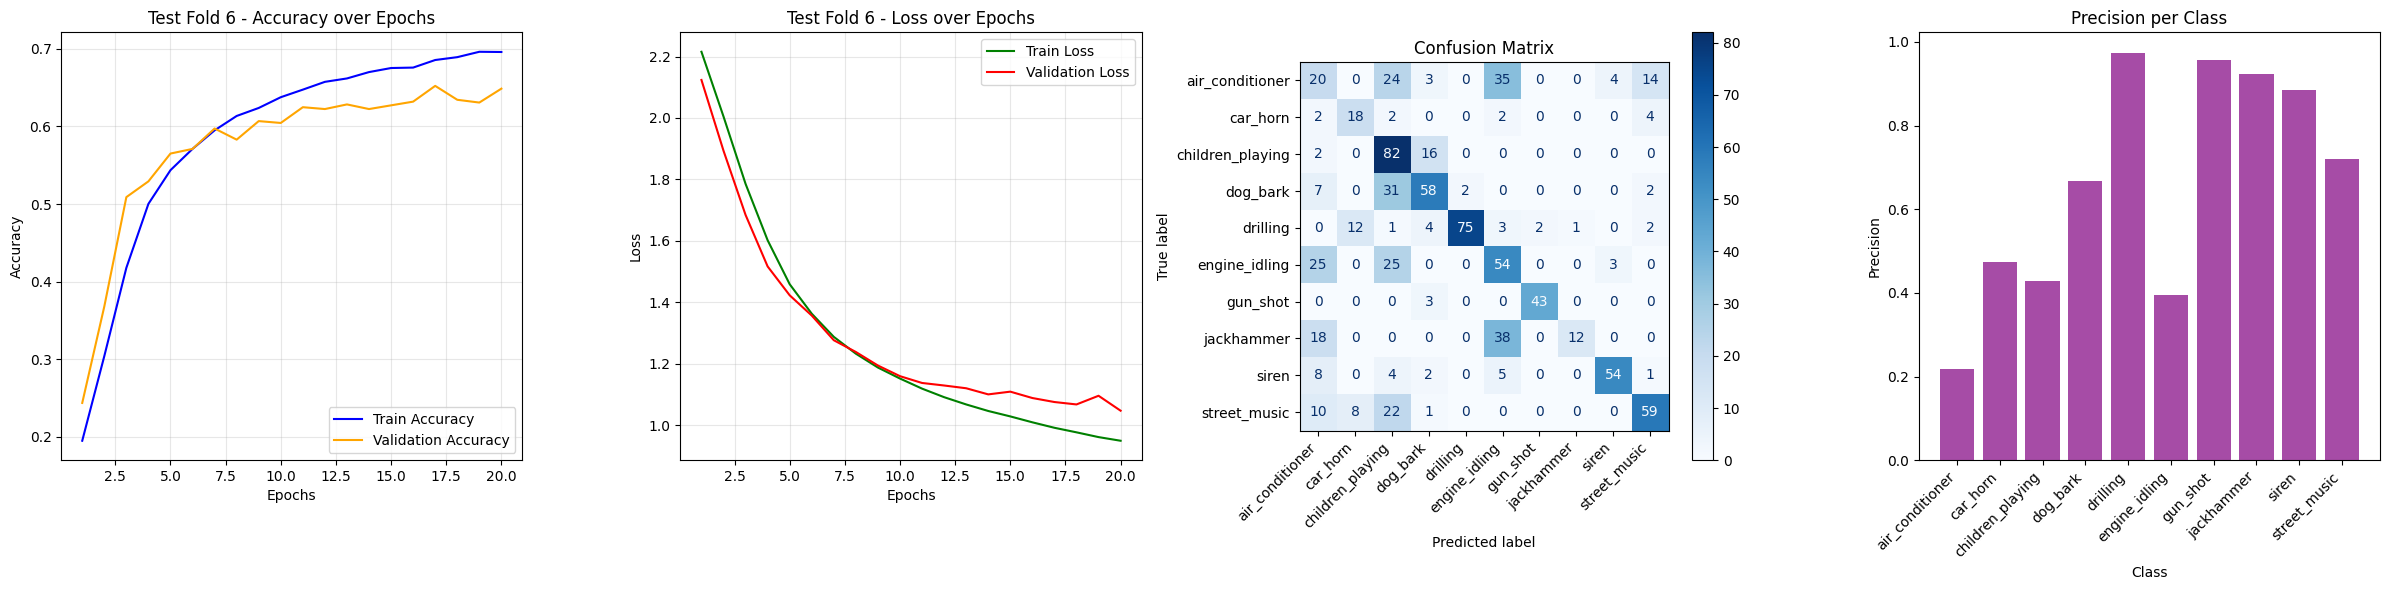

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 7 Mean Accuracy: 0.5562, Std Dev: 0.0130


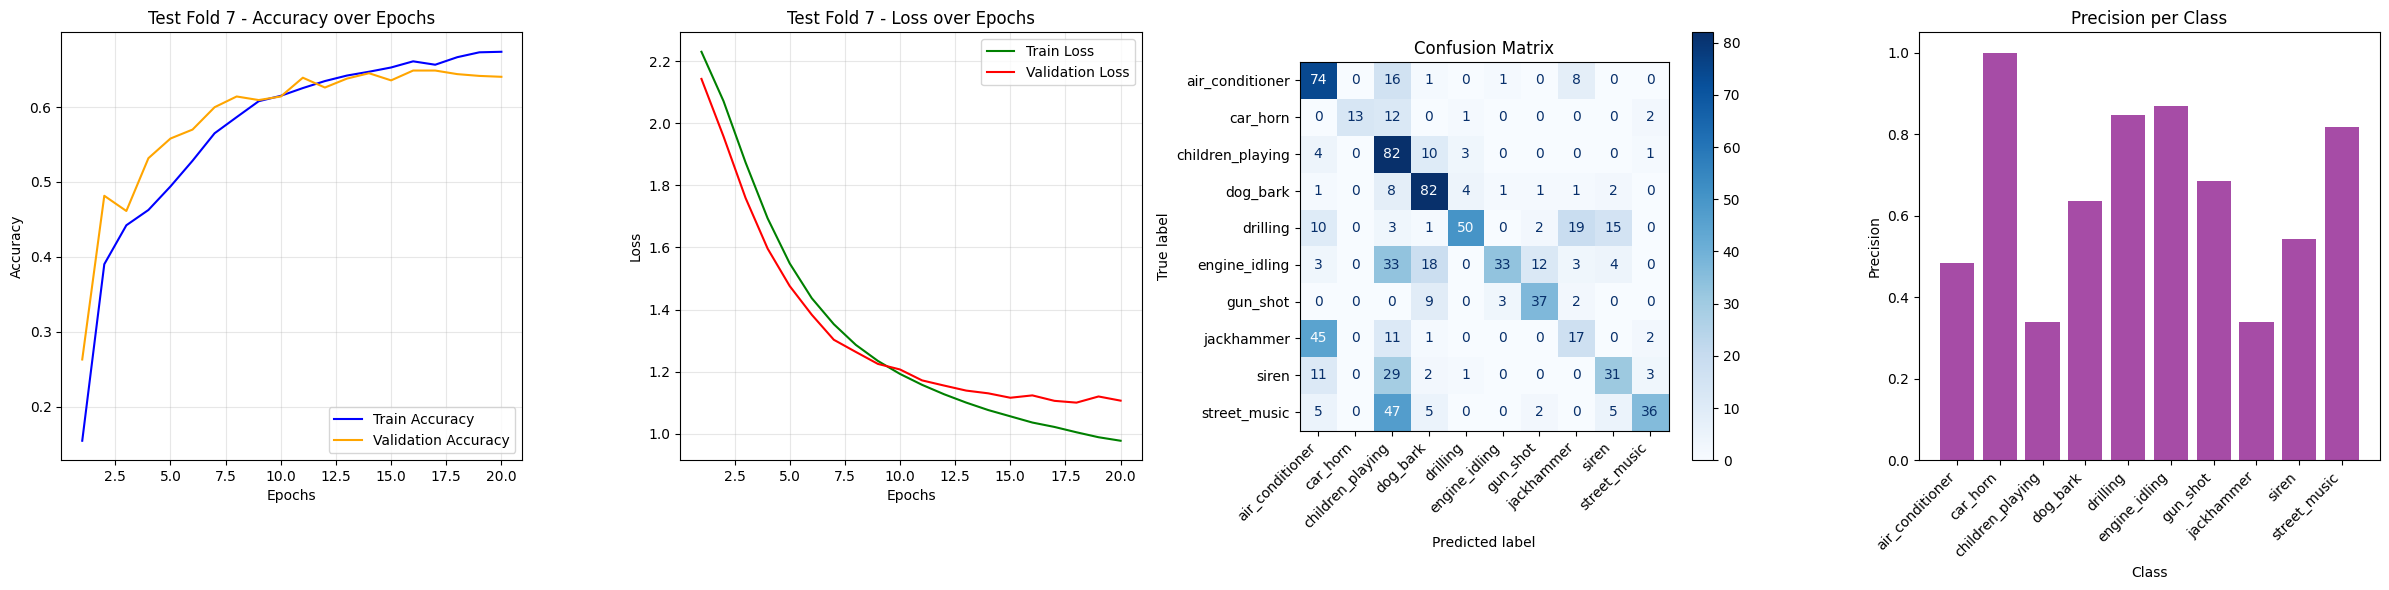

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 8 Mean Accuracy: 0.6232, Std Dev: 0.0195


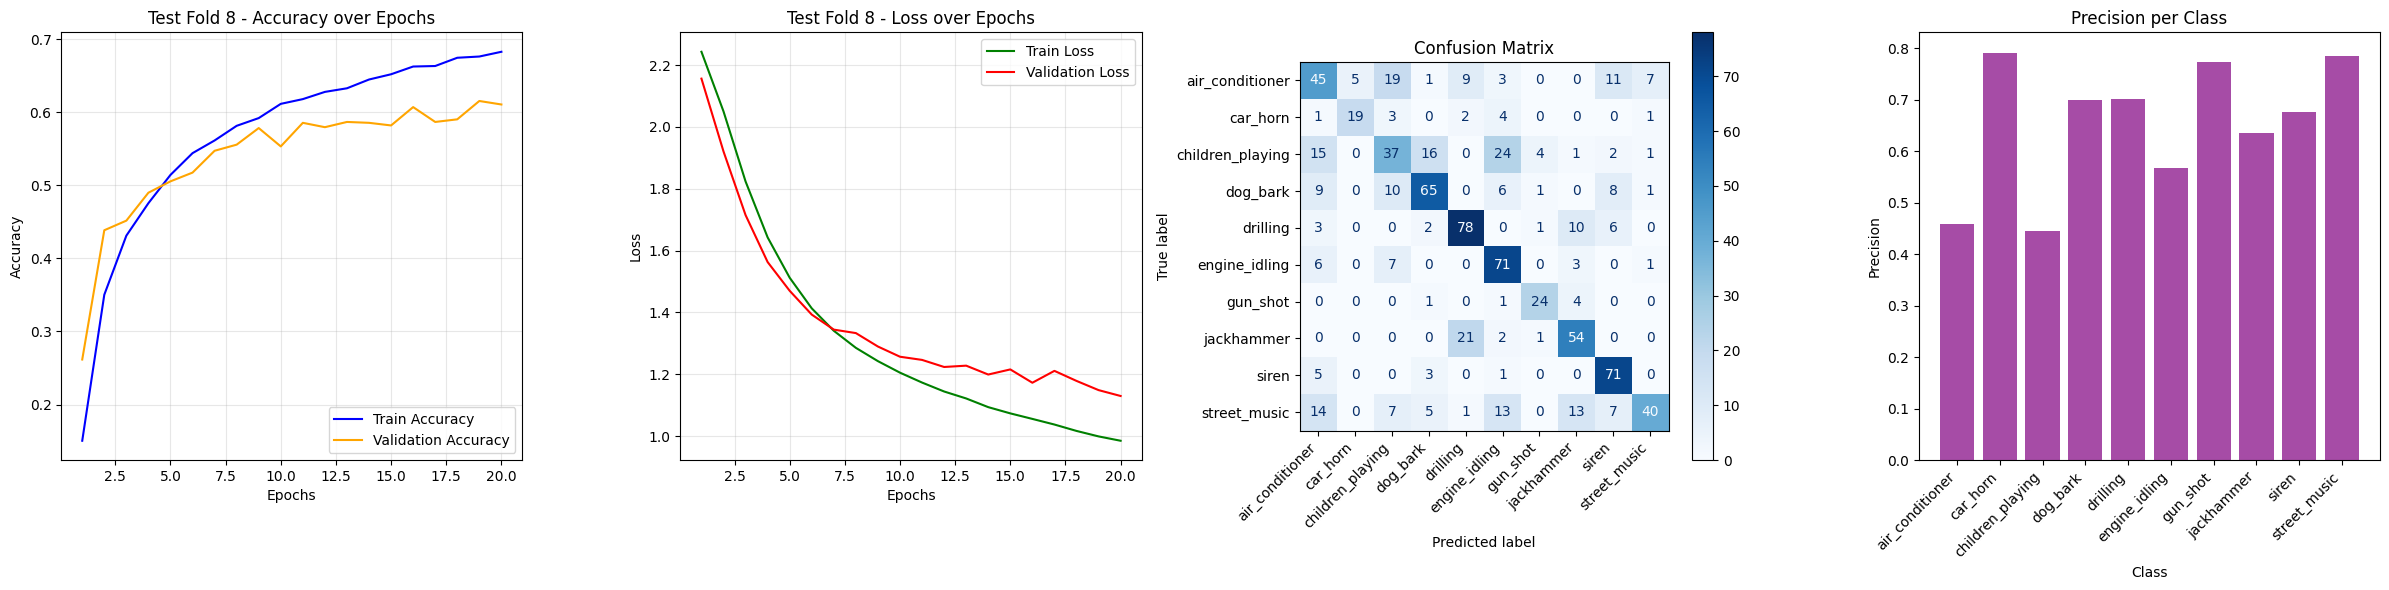

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 9 Mean Accuracy: 0.5606, Std Dev: 0.0170


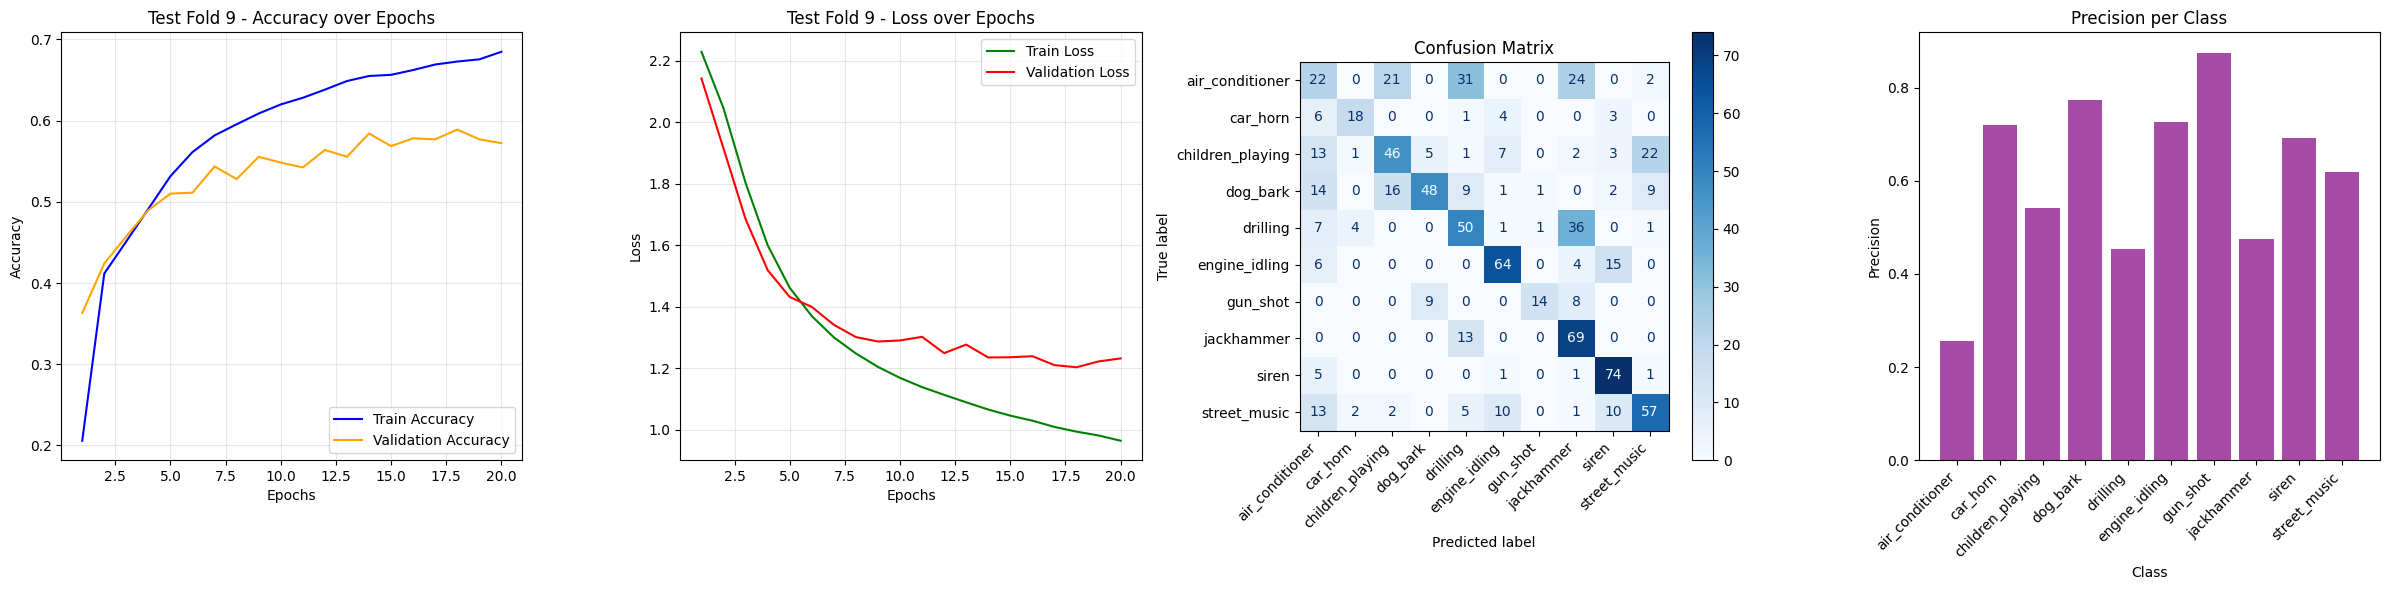

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 10 Mean Accuracy: 0.6158, Std Dev: 0.0178


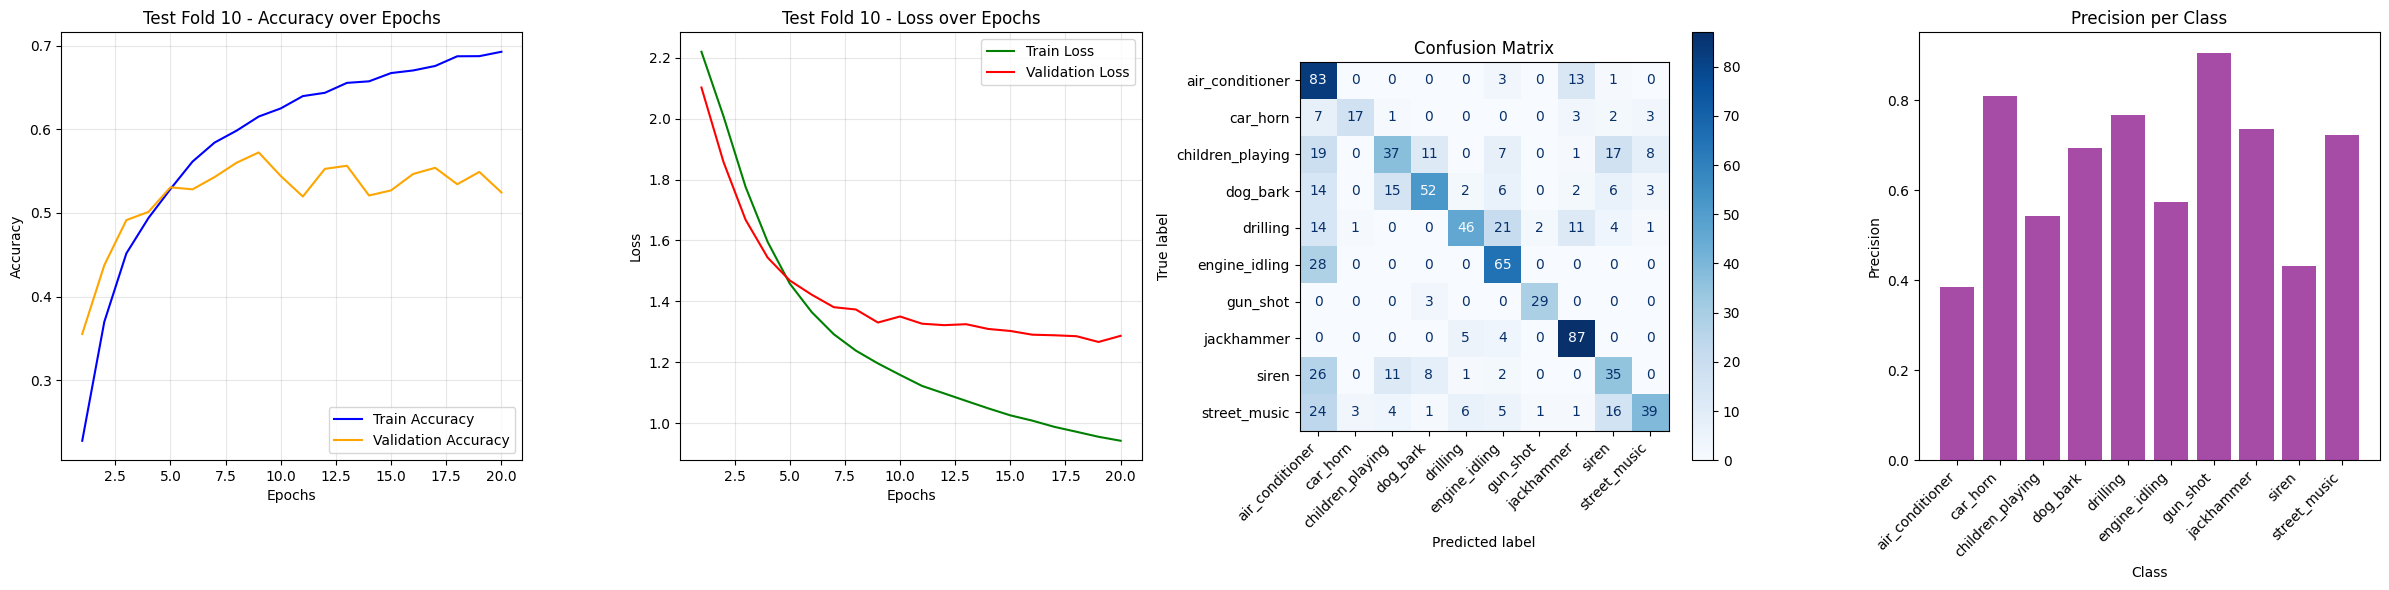

Final Mean Accuracy: 0.5898, Std Dev: 0.0434


[(1, 2, <keras.src.callbacks.history.History at 0x312e6bd60>),
 (1, 3, <keras.src.callbacks.history.History at 0x3150e0d60>),
 (1, 4, <keras.src.callbacks.history.History at 0x3131c0280>),
 (1, 5, <keras.src.callbacks.history.History at 0x319a47fa0>),
 (1, 6, <keras.src.callbacks.history.History at 0x315015e50>),
 (1, 7, <keras.src.callbacks.history.History at 0x315dfd100>),
 (1, 8, <keras.src.callbacks.history.History at 0x31e49ae20>),
 (1, 9, <keras.src.callbacks.history.History at 0x3201f6430>),
 (1, 10, <keras.src.callbacks.history.History at 0x3214b7160>),
 (2, 1, <keras.src.callbacks.history.History at 0x324bf1c70>),
 (2, 3, <keras.src.callbacks.history.History at 0x34a6ddcd0>),
 (2, 4, <keras.src.callbacks.history.History at 0x3221ae7c0>),
 (2, 5, <keras.src.callbacks.history.History at 0x349b4d790>),
 (2, 6, <keras.src.callbacks.history.History at 0x34fa2fe80>),
 (2, 7, <keras.src.callbacks.history.History at 0x350cc7670>),
 (2, 8, <keras.src.callbacks.history.History at 0x34f3

In [ ]:
files = [f'datasets/urbansounds_features_fold{i}.csv' for i in range(1, 11)]

cross_validate_with_test_and_plot(files, files, best_config)

The mean accuracy of the model on the original dataset was 0.5898, with a standard deviation of 0.0434. 

As seen in the confusion matrix for each fold, although the model performs well in terms of overall accuracy, it struggles to distinguish between certain classes in the dataset. This indicates that while the model shows decent performance, it still faces challenges in accurately identifying some classes, which may affect its effectiveness"

The augmented dataset slightly improved the model's accuracy (0.5974 vs. 0.5898 for the original dataset), but with a slightly higher standard deviation (0.0546 vs. 0.0434). This suggests that while data augmentation provides some performance gains, it also introduces more variability, potentially indicating overfitting to specific augmented examples. Further refinement of the augmentation strategy may lead to more consistent and robust improvements.


#### 4.3. Average Cross validation and precision per class <a name="avg-precision"></a>
[[go back to the topic]](#evaluation)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


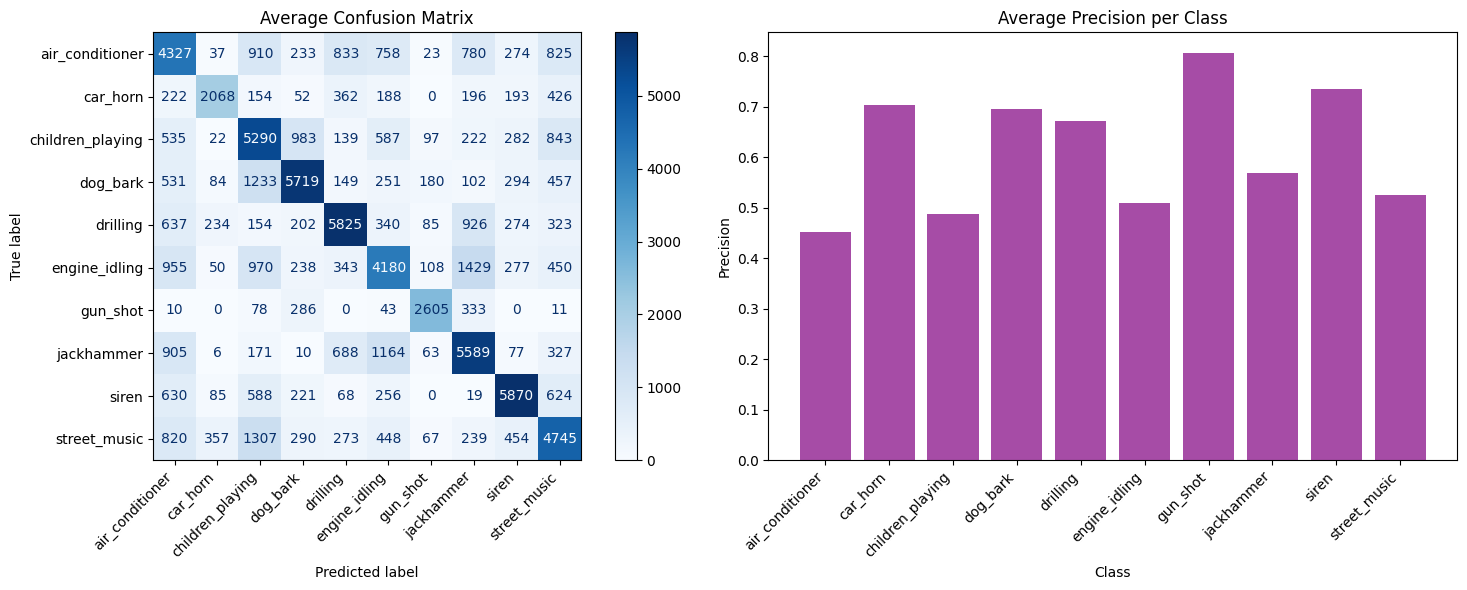

[(1, 2, <keras.src.callbacks.history.History at 0x44ec466a0>),
 (1, 3, <keras.src.callbacks.history.History at 0x4c77f4a60>),
 (1, 4, <keras.src.callbacks.history.History at 0x4b1317580>),
 (1, 5, <keras.src.callbacks.history.History at 0x4a9e7ca30>),
 (1, 6, <keras.src.callbacks.history.History at 0x4bc9d5e20>),
 (1, 7, <keras.src.callbacks.history.History at 0x4caddbdf0>),
 (1, 8, <keras.src.callbacks.history.History at 0x3e480b310>),
 (1, 9, <keras.src.callbacks.history.History at 0x3e54d65b0>),
 (1, 10, <keras.src.callbacks.history.History at 0x3e5565bb0>),
 (2, 1, <keras.src.callbacks.history.History at 0x4d927a940>),
 (2, 3, <keras.src.callbacks.history.History at 0x4dafe8850>),
 (2, 4, <keras.src.callbacks.history.History at 0x4dd1ae0a0>),
 (2, 5, <keras.src.callbacks.history.History at 0x4df6d8d60>),
 (2, 6, <keras.src.callbacks.history.History at 0x4e2ca29d0>),
 (2, 7, <keras.src.callbacks.history.History at 0x4df808790>),
 (2, 8, <keras.src.callbacks.history.History at 0x4e1e

In [ ]:
def generate_classification_table(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
  
    table_data = []
    for class_name in class_names:
        metrics = report[class_name]
        table_data.append([
            class_name, 
            f"{metrics['precision']:.4f}", 
            f"{metrics['recall']:.4f}", 
            f"{metrics['f1-score']:.4f}"
        ])
   
    overall = report['weighted avg']
    table_data.append([
        "Weighted Avg", 
        f"{overall['precision']:.4f}", 
        f"{overall['recall']:.4f}", 
        f"{overall['f1-score']:.4f}"
    ])
    
    headers = ["Class", "Precision", "Recall", "F1-Score"]
    table = tabulate(table_data, headers=headers, tablefmt="fancy_grid", numalign="center", stralign="center")
    print(table)

def plot_final_metrics(cm, precision_per_class, class_names):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=axs[0])
    axs[0].set_title("Average Confusion Matrix")
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')

    axs[1].bar(range(len(class_names)), precision_per_class, color='purple', alpha=0.7)
    axs[1].set_xticks(range(len(class_names)))
    axs[1].set_xticklabels(class_names, rotation=45, ha='right')
    axs[1].set_title("Average Precision per Class")
    axs[1].set_xlabel("Class")
    axs[1].set_ylabel("Precision")

    plt.tight_layout()
    plt.show()

def cross_validate_with_test_and_plot(files, augmented_files, best_config):
    class_names = [
        "air_conditioner", "car_horn", "children_playing", "dog_bark", 
        "drilling", "engine_idling", "gun_shot", "jackhammer", 
        "siren", "street_music"
    ]
    folds = list(range(1, 11))
    all_histories = []
    all_accuracies = []
    all_losses = []
    all_y_true = []
    all_y_pred = []

    for test_fold in folds:
        #print(f"Analyzing Test Fold {test_fold}")

        train_val_folds = [fold for fold in folds if fold != test_fold]
        fold_accuracies = []
        fold_losses = []

        for val_fold in train_val_folds:
            train_folds = [fold for fold in train_val_folds if fold != val_fold]
        
            X_train, y_train = [], []
            for fold in train_folds:
                X_temp, y_temp = load_augmented_data(fold, augmented_files)
                X_train.append(X_temp)
                y_train.append(y_temp)
            X_train = np.concatenate(X_train, axis=0)
            y_train = np.concatenate(y_train, axis=0)

            X_val, y_val = load_augmented_data(val_fold, augmented_files)
            X_test, y_test = load_fold_data(test_fold, files)

            history = train_evaluate_model(best_config, X_train, y_train, X_val, y_val)
            all_histories.append((test_fold, val_fold, history))

            model = MLP(
                input_dim=X_train.shape[1],
                output_dim=10,
                hidden_units=best_config['hidden_units'],
                dropout_rate=best_config['dropout_rate'],
                activations=best_config['activations'],
                regularization_type=best_config.get('regularization_type', None),
                regularization_value=best_config.get('regularization_value', 0.01)
            )
            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=best_config['learning_rate']),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy']
            )
            model.fit(X_train, y_train, batch_size=best_config['batch_size'], epochs=best_config['epochs'], verbose=0)
            y_pred = np.argmax(model.predict(X_test), axis=1)

            _, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
            fold_accuracies.append(val_accuracy)
            all_y_true.append(y_test)
            all_y_pred.append(y_pred)

        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        all_accuracies.extend(fold_accuracies)

    final_mean_accuracy = np.mean(all_accuracies)
    final_std_accuracy = np.std(all_accuracies)
    print(f"Final Mean Accuracy: {final_mean_accuracy:.4f}, Std Dev: {final_std_accuracy:.4f}")

    all_y_true = np.concatenate(all_y_true)
    all_y_pred = np.concatenate(all_y_pred)

    cm = confusion_matrix(all_y_true, all_y_pred)
    class_report = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
    precision_per_class = [class_report[name]['precision'] for name in class_names]
    generate_classification_table(all_y_true, all_y_pred, class_names)
    plot_final_metrics(cm, precision_per_class, class_names)

    return all_histories

cross_validate_with_test_and_plot(files, files, best_config)


### 5. Conclusion <a name="conclusion"></a>
[[go back to the top]](#contents)

The model achieved a final mean accuracy of 0.5876 with a standard deviation of 0.0427. It performs well on certain classes, such as "gun_shot" and "siren," showing strong precision and recall. However, it struggles with classes like "air_conditioner," where both precision and recall are notably lower. This suggests that while the model is effective in some categories, it has difficulty distinguishing certain sounds, indicating areas for improvement in class balance and model robustness.